**Integrantes:**

Laura Cristina Caro Puerta  | C.C. 1020472557

Lady Jhoana Rodas Zuluaga   | C.C. 1017229534

https://www.kaggle.com/c/home-credit-default-risk/overview

**Objetivo:**

Home Credit busca un modelo de aprendizaje automático para hacer predicciones del cumplimiento de pago de sus clientes, así se asegurará de que no se rechace a los clientes capaces de reembolsar y de que los préstamos se otorguen con un capital, vencimiento y calendario de reembolso que facilitará el éxito en sus clientes.

**Evaluación:**

El modelo se evalúa con el área bajo la curva ROC entre la probabilidad pronosticada y el objetivo observado.

# DATOS

## CARGA DE DATOS

Se cargan los datos de Home Credit Default Risk desde Kaggle con la siguiente metodología: 

1. Descargar el archivo de configuración de Kaggle*:
*   Iniciar sesión en la cuenta de Kaggle.
*   Elegir 'Account' en el menú desplegable.
*   Desplazar hacia abajo hasta la sección 'API' y hacer clic en 'Create New API Token'
*    Descargar el archivo kaggle.json y guardar en la máquina local. Este es el archivo de configuración con sus credenciales que utilizará para acceder a los conjuntos de datos de Kaggle desde Colab.

2. Cargar el archivo 'kaggle.json' de configuración en Colab cuando se solicite 'Elegir archivos'.


*Archivo 'kaggle.json' compartido en Drive.







In [ ]:
# Carga de datos: Cargar el archivo kaggle.json descargado en la sección 'API'
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"ladyrodas","key":"c0cdb8e9a357d0d660d4d72cb1e452a9"}'}

In [ ]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
! chmod 600 /content/kaggle.json

In [ ]:
! kaggle competitions download -c home-credit-default-risk

home-credit-default-risk.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q "/content/home-credit-default-risk.zip"

replace HomeCredit_columns_description.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace POS_CASH_balance.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace application_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace application_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace bureau.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace bureau_balance.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace credit_card_balance.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace installments_payments.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace previous_application.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


Se importan las principales librerías para utilizar en el desarrollo del análisis.

In [ ]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy.stats import mode
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

## IDENTIFICACIÓN DE VARIABLES

**home_credit_description**

*   Este archivo contiene descripciones de las columnas en los distintos archivos de datos, permitiendo entender el contexto de todas las variables en el problema.

In [ ]:
home_credit_description=pd.read_csv("HomeCredit_columns_description.csv", sep=",",encoding='cp1252') #Preguntar por encoding
pd.set_option("max_rows", None)
pd.set_option("max_colwidth", None)
home_credit_description.head(2)

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN


In [ ]:
home_credit_description.shape

(219, 5)

Para el desarrollo del proyecto se utilizan 3 de las 8 tablas iniciales del problema, las cuales son: 'application_train', 'bureau' y 'previous_application'.

**application_train**

*   Esta es la tabla principal para Train (con TARGET), contiene datos estáticos para todas las aplicaciones de los clientes, donde una fila representa un préstamo en nuestra muestra de datos.

In [ ]:
application_train=pd.read_csv("application_train.csv", sep=",", decimal=".")
pd.set_option('display.max_columns', None)
application_train.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Tamaño del Dataframe
application_train.shape 

(307511, 122)

In [ ]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [ ]:
pd.set_option('display.max_rows', None)
application_train.dtypes

SK_ID_CURR                        int64
TARGET                            int64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64


Se detecta que la tabla 'application_train' cuenta con 307511 registros (filas) y 122 variables (columnas), comprendiendo 65 variables de tipo flotante, 41 de tipo entero y 16 de tipo objeto.

De acuerdo con la revisión preliminar de las variables contenidas en el DataFrame, se observan 20 variables relacionadas a la entrega de documentos por parte del cliente. Por esto se crea una nueva columna 'FLAG_DOCUMENT_SUM' con el número total de documentos entregados por cada cliente.

In [ ]:
# Se crea una nueva columna con la suma del total de documentos entregados
application_train["FLAG_DOCUMENT_SUM"]=application_train["FLAG_DOCUMENT_2"]+application_train["FLAG_DOCUMENT_3"]+application_train["FLAG_DOCUMENT_4"]+application_train["FLAG_DOCUMENT_5"]+application_train["FLAG_DOCUMENT_6"]+application_train["FLAG_DOCUMENT_7"]+application_train["FLAG_DOCUMENT_8"]+application_train["FLAG_DOCUMENT_9"]+application_train["FLAG_DOCUMENT_10"]+application_train["FLAG_DOCUMENT_11"]+application_train["FLAG_DOCUMENT_12"]+application_train["FLAG_DOCUMENT_13"]+application_train["FLAG_DOCUMENT_14"]+application_train["FLAG_DOCUMENT_15"]+application_train["FLAG_DOCUMENT_16"]+application_train["FLAG_DOCUMENT_17"]+application_train["FLAG_DOCUMENT_18"]+application_train["FLAG_DOCUMENT_19"]+application_train["FLAG_DOCUMENT_20"]+application_train["FLAG_DOCUMENT_21"]

# Se eliminan las columnas de documentos entregados
application_train.drop(["FLAG_DOCUMENT_2","FLAG_DOCUMENT_3","FLAG_DOCUMENT_4","FLAG_DOCUMENT_5","FLAG_DOCUMENT_6","FLAG_DOCUMENT_7","FLAG_DOCUMENT_8","FLAG_DOCUMENT_9","FLAG_DOCUMENT_10","FLAG_DOCUMENT_11","FLAG_DOCUMENT_12","FLAG_DOCUMENT_13","FLAG_DOCUMENT_14","FLAG_DOCUMENT_15","FLAG_DOCUMENT_16","FLAG_DOCUMENT_17","FLAG_DOCUMENT_18","FLAG_DOCUMENT_19","FLAG_DOCUMENT_20","FLAG_DOCUMENT_21"],axis="columns", inplace=True)
application_train.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,FLAG_DOCUMENT_SUM
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
# Conteo de nulos diferentes a 0 por cada variable
null_application_train = application_train.isna().sum()
Nulos_application_train=null_application_train[null_application_train!=0]
Nulos_application_train

AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
OWN_CAR_AGE                     202929
OCCUPATION_TYPE                  96391
CNT_FAM_MEMBERS                      2
EXT_SOURCE_1                    173378
EXT_SOURCE_2                       660
EXT_SOURCE_3                     60965
APARTMENTS_AVG                  156061
BASEMENTAREA_AVG                179943
YEARS_BEGINEXPLUATATION_AVG     150007
YEARS_BUILD_AVG                 204488
COMMONAREA_AVG                  214865
ELEVATORS_AVG                   163891
ENTRANCES_AVG                   154828
FLOORSMAX_AVG                   153020
FLOORSMIN_AVG                   208642
LANDAREA_AVG                    182590
LIVINGAPARTMENTS_AVG            210199
LIVINGAREA_AVG                  154350
NONLIVINGAPARTMENTS_AVG         213514
NONLIVINGAREA_AVG               169682
APARTMENTS_MODE                 156061
BASEMENTAREA_MODE               179943
YEARS_BEGINEXPLUATATION_M

In [ ]:
# Porcentaje de datos nulos por cada variable 
DF_Nulos_application_train = pd.DataFrame([Nulos_application_train,100*(Nulos_application_train/307511)],index=["Cantidad de Nulos","Porcentaje de Nulos"]).T

# Filtro de variables con valores nulos mayores al 20%
DF_Nulos_application_train_20=DF_Nulos_application_train[DF_Nulos_application_train["Porcentaje de Nulos"]>20]
DF_Nulos_application_train_20

,Cantidad de Nulos,Porcentaje de Nulos
OWN_CAR_AGE,202929.0,65.990810
OCCUPATION_TYPE,96391.0,31.345545
EXT_SOURCE_1,173378.0,56.381073
APARTMENTS_AVG,156061.0,50.749729
BASEMENTAREA_AVG,179943.0,58.515956
YEARS_BEGINEXPLUATATION_AVG,150007.0,48.781019
YEARS_BUILD_AVG,204488.0,66.497784
COMMONAREA_AVG,214865.0,69.872297
ELEVATORS_AVG,163891.0,53.295980
ENTRANCES_AVG,154828.0,50.348768


In [ ]:
# Variables eliminadas por cantidad de nulos superior al 30%
application_train.drop(["OWN_CAR_AGE","OCCUPATION_TYPE","EXT_SOURCE_1","APARTMENTS_AVG","BASEMENTAREA_AVG","YEARS_BEGINEXPLUATATION_AVG","YEARS_BUILD_AVG","COMMONAREA_AVG","ELEVATORS_AVG","ENTRANCES_AVG","FLOORSMAX_AVG","FLOORSMIN_AVG","LANDAREA_AVG","LIVINGAPARTMENTS_AVG","LIVINGAREA_AVG","NONLIVINGAPARTMENTS_AVG","NONLIVINGAREA_AVG","APARTMENTS_MODE","BASEMENTAREA_MODE","YEARS_BEGINEXPLUATATION_MODE","YEARS_BUILD_MODE","COMMONAREA_MODE","ELEVATORS_MODE","ENTRANCES_MODE","FLOORSMAX_MODE","FLOORSMIN_MODE","LANDAREA_MODE","LIVINGAPARTMENTS_MODE","LIVINGAREA_MODE","NONLIVINGAPARTMENTS_MODE","NONLIVINGAREA_MODE","APARTMENTS_MEDI","BASEMENTAREA_MEDI","YEARS_BEGINEXPLUATATION_MEDI","YEARS_BUILD_MEDI","COMMONAREA_MEDI","ELEVATORS_MEDI","ENTRANCES_MEDI","FLOORSMAX_MEDI","FLOORSMIN_MEDI","LANDAREA_MEDI","LIVINGAPARTMENTS_MEDI","LIVINGAREA_MEDI","NONLIVINGAPARTMENTS_MEDI","NONLIVINGAREA_MEDI","FONDKAPREMONT_MODE","HOUSETYPE_MODE","TOTALAREA_MODE","WALLSMATERIAL_MODE","EMERGENCYSTATE_MODE"],axis="columns", inplace=True)

In [ ]:
# Matriz de correlación
Matriz_Correlacion_application_train = application_train.corr(method='pearson')
Matriz_Correlacion_application_train

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,FLAG_DOCUMENT_SUM
SK_ID_CURR,1.000000,-0.002108,-0.001129,-0.001820,-0.000343,-0.000433,-0.000232,0.000849,-0.001500,0.001366,-0.000973,-0.000384,0.002804,-0.001337,-0.000415,0.002815,0.002753,0.000281,-0.002895,-0.001075,-0.001138,0.000350,-0.000283,0.001097,0.002903,-0.001885,-0.001582,0.000067,0.002342,0.000222,-0.001409,-0.000082,-0.001423,0.001187,-0.000858,-0.002672,-0.002193,0.002099,0.000485,0.001025,0.004659,-0.001679
TARGET,-0.002108,1.000000,0.019187,-0.003982,-0.030369,-0.012817,-0.039645,-0.037227,0.078239,-0.044932,0.041975,0.051457,0.000534,0.045982,0.028524,0.000370,-0.023806,-0.001758,0.009308,0.058899,0.060893,-0.024166,0.005576,0.006942,0.002819,0.044395,0.050994,0.032518,-0.160472,-0.178919,0.009131,0.032248,0.009022,0.031276,0.055218,0.000930,0.002704,0.000788,-0.012462,-0.002022,0.019930,0.017193
CNT_CHILDREN,-0.001129,0.019187,1.000000,0.012882,0.002145,0.021374,-0.001827,-0.025573,0.330938,-0.239818,0.183395,-0.028019,0.001041,0.240714,0.055630,-0.000794,-0.029906,0.022619,0.879161,0.025423,0.024781,-0.007292,-0.013319,0.008185,0.014835,0.020072,0.070650,0.069957,-0.018015,-0.042710,0.015593,-0.001262,0.015232,-0.001861,-0.005865,-0.000410,-0.000366,-0.002436,-0.010808,-0.007836,-0.041550,-0.016357
AMT_INCOME_TOTAL,-0.001820,-0.003982,0.012882,1.000000,0.156870,0.191657,0.159610,0.074796,0.027261,-0.064223,0.027805,0.008506,0.000325,0.063994,-0.017193,-0.008290,0.000159,0.038378,0.016342,-0.085465,-0.091735,0.036459,0.031191,0.062340,0.058059,0.003574,0.006431,0.008285,0.060925,-0.030229,-0.013099,-0.013244,-0.013015,-0.013135,-0.018585,0.000709,0.002944,0.002387,0.024700,0.004859,0.011690,0.013580
AMT_CREDIT,-0.000343,-0.030369,0.002145,0.156870,1.000000,0.770138,0.986968,0.099738,-0.055436,-0.066838,0.009621,-0.006575,0.001436,0.065519,-0.021085,0.023653,0.026213,0.016632,0.063160,-0.101776,-0.110915,0.052738,0.024010,0.051929,0.052609,-0.026886,-0.018856,0.000081,0.131228,0.043516,0.000190,-0.021229,0.000239,-0.023767,-0.073701,-0.003906,0.004238,-0.001275,0.054451,0.015925,-0.048448,0.209468
AMT_ANNUITY,-0.000433,-0.012817,0.021374,0.191657,0.770138,1.000000,0.775109,0.118429,0.009445,-0.104332,0.038514,0.011268,0.000149,0.103533,-0.024803,0.022350,0.010802,0.071709,0.075539,-0.128525,-0.141682,0.052269,0.041299,0.079420,0.074550,-0.006214,0.000896,0.010084,0.125804,0.030752,-0.011987,-0.022833,-0.011731,-0.024001,-0.063747,0.003861,0.002185,0.013881,0.039148,0.010124,-0.011320,0.193025
AMT_GOODS_PRICE,-0.000232,-0.039645,-0.001827,0.159610,0.986968,0.775109,1.000000,0.103520,-0.053442,-0.064842,0.011565,-0.009267,0.001399,0.063487,0.001086,0.020706,0.042179,0.017048,0.061185,-0.103786,-0.112208,0.062320,0.026111,0.053171,0.052864,-0.027212,-0.020333,-0.001309,0.139367,0.047717,0.000328,-0.022244,0.000347,-0.024506,-0.076313,-0.003237,0.004677,-0.001007,0.056422,0.016432,-0.050998,0.178776
REGION_POPULATION_RELATIVE,0.000849,-0.037227,-0.025573,0.074796,0.099738,0.118429,0.103520,1.000000,-0.029582,-0.003980,-0.053820,-0.003993,0.001333,0.004045,-0.015628,-0.012478,0.090939,0.040012,-0.024209,-0.532877,-0.531535,0.171285,0.002118,0.056944,0.081016,-0.050499,-0.044057,-0.015188,0.198924,-0.006001,-0.011160,0.006

In [ ]:
# REGION_RATING_CLIENT tiene correlación del 95% con la variable REGION_RATING_CLIENT_W_CITY, OBS_30 tiene correlación del 99,8% con OBS_60, DEF_30 tiene correlación del 86% con DEF_60.LIVE_REGION_NOT_WORK_REGION tiene una correlación del 86% con REG_REGION.LIVE_CITY_NOT_WORK_CITY tiene una correlación del 82% con REG_CITY_NOT_WORK_CITY. CNT_CHILDREN tiene una correlación del 87,9% con CNT_FAM_MEMBERS.AMT_ANNUITY y AMT_GOODS_PRICE tienen correlación con AMT_CREDIT con un 77% y 98,7% respectivamente.FLAG_EMP_PHONE tiene una correlación del -99% con DAYS_EMPLOYED.
application_train.drop(["REGION_RATING_CLIENT","OBS_30_CNT_SOCIAL_CIRCLE","DEF_30_CNT_SOCIAL_CIRCLE","LIVE_REGION_NOT_WORK_REGION","LIVE_CITY_NOT_WORK_CITY","CNT_CHILDREN","AMT_ANNUITY","AMT_GOODS_PRICE","FLAG_EMP_PHONE"],axis="columns", inplace=True)
application_train.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,FLAG_DOCUMENT_SUM
0,100002,1,Cash loans,M,N,Y,202500.0,406597.5,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,0,1,1,0,1.0,2,WEDNESDAY,10,0,0,0,0,Business Entity Type 3,0.262949,0.139376,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,100003,0,Cash loans,F,N,N,270000.0,1293502.5,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,0,1,1,0,2.0,1,MONDAY,11,0,0,0,0,School,0.622246,NaN,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
# Imputación de categorías XNA
application_train["CODE_GENDER"]=application_train["CODE_GENDER"].replace("XNA",np.nan) 
application_train["ORGANIZATION_TYPE"]=application_train["ORGANIZATION_TYPE"].replace("XNA",np.nan) 

print(application_train["CODE_GENDER"].unique())
print(application_train["ORGANIZATION_TYPE"].unique())

['M' 'F' nan]
['Business Entity Type 3' 'School' 'Government' 'Religion' 'Other' nan
 'Electricity' 'Medicine' 'Business Entity Type 2' 'Self-employed'
 'Transport: type 2' 'Construction' 'Housing' 'Kindergarten'
 'Trade: type 7' 'Industry: type 11' 'Military' 'Services'
 'Security Ministries' 'Transport: type 4' 'Industry: type 1' 'Emergency'
 'Security' 'Trade: type 2' 'University' 'Transport: type 3' 'Police'
 'Business Entity Type 1' 'Postal' 'Industry: type 4' 'Agriculture'
 'Restaurant' 'Culture' 'Hotel' 'Industry: type 7' 'Trade: type 3'
 'Industry: type 3' 'Bank' 'Industry: type 9' 'Insurance' 'Trade: type 6'
 'Industry: type 2' 'Transport: type 1' 'Industry: type 12' 'Mobile'
 'Trade: type 1' 'Industry: type 5' 'Industry: type 10' 'Legal Services'
 'Advertising' 'Trade: type 5' 'Cleaning' 'Industry: type 13'
 'Trade: type 4' 'Telecom' 'Industry: type 8' 'Realtor' 'Industry: type 6']


***Unión de categorías:*** con el fin de reducir la cantidad de categorías de la variable 'ORGANIZATION_TYPE' se agrupan las categorías semejantes, como se muestra a continuación.

**Business Entity:** Business Entity Type 1, Business Entity Type 2, Business Entity Type 3

**Industry:** Industry: type 1, Industry: type 2, Industry: type 3, Industry: type 4, Industry: type 5, Industry: type 6, Industry: type 7, Industry: type 8, Industry: type 9, Industry: type 10, Industry: type 11, Industry: type 12, Industry: type 13

**Trade:** Trade: type 1, Trade: type 2, Trade: type 3, Trade: type 4, Trade: type 5, Trade: type 6, Trade: type 7

**Transport:** Transport: type 1, Transport: type 2, Transport: type 3, Transport: type 4

**Education:** School, Kindergarten, University 

**Government:** Government, Security, Military, Police, Security Ministries

**Medicine:** Medicine, Emergency

**Self-employed** 

**Other:** Other, Construction, Housing, Realtor, Bank, Agriculture,   Postal, Electricity, Hotel, Restaurant, Services, Legal Services, Insurance, Telecom, Advertising, Culture, Mobile, Cleaning, Religion                     

In [ ]:
# Agrupando algunas de las clases de la variable ORGANIZATION_TYPE 
application_train['ORGANIZATION_TYPE']=application_train['ORGANIZATION_TYPE'].replace(['Business Entity Type 1', 'Business Entity Type 2', 'Business Entity Type 3'],'Business Entity')
application_train['ORGANIZATION_TYPE']=application_train['ORGANIZATION_TYPE'].replace(['Industry: type 1', 'Industry: type 2', 'Industry: type 3', 'Industry: type 4', 'Industry: type 5', 'Industry: type 6', 'Industry: type 7', 'Industry: type 8', 'Industry: type 9', 'Industry: type 10', 'Industry: type 11', 'Industry: type 12', 'Industry: type 13'],'Industry')
application_train['ORGANIZATION_TYPE']=application_train['ORGANIZATION_TYPE'].replace(['Trade: type 1', 'Trade: type 2', 'Trade: type 3', 'Trade: type 4', 'Trade: type 5', 'Trade: type 6', 'Trade: type 7'],'Trade')
application_train['ORGANIZATION_TYPE']=application_train['ORGANIZATION_TYPE'].replace(['Transport: type 1', 'Transport: type 2', 'Transport: type 3', 'Transport: type 4'],'Transport')
application_train['ORGANIZATION_TYPE']=application_train['ORGANIZATION_TYPE'].replace(['School', 'Kindergarten', 'University'],'Education')
application_train['ORGANIZATION_TYPE']=application_train['ORGANIZATION_TYPE'].replace(['Security', 'Military', 'Police', 'Security Ministries'],'Government')
application_train['ORGANIZATION_TYPE']=application_train['ORGANIZATION_TYPE'].replace(['Emergency'],'Medicine')
application_train['ORGANIZATION_TYPE']=application_train['ORGANIZATION_TYPE'].replace(['Construction', 'Housing', 'Realtor', 'Bank', 'Agriculture', 'Postal', 'Electricity', 'Hotel', 'Restaurant', 'Services', 'Legal Services', 'Insurance', 'Telecom', 'Advertising', 'Culture', 'Mobile', 'Cleaning', 'Religion'],'Other')
application_train.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,FLAG_DOCUMENT_SUM
0,100002,1,Cash loans,M,N,Y,202500.0,406597.5,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,0,1,1,0,1.0,2,WEDNESDAY,10,0,0,0,0,Business Entity,0.262949,0.139376,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,100003,0,Cash loans,F,N,N,270000.0,1293502.5,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,0,1,1,0,2.0,1,MONDAY,11,0,0,0,0,Education,0.622246,NaN,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
freq_ORGANIZATION_TYPE=application_train['ORGANIZATION_TYPE'].value_counts() 
print(freq_ORGANIZATION_TYPE)

Business Entity    84529
Other              42127
Self-employed      38412
Government         20600
Education          17100
Trade              14315
Industry           14311
Medicine           11753
Transport           8990
Name: ORGANIZATION_TYPE, dtype: int64


In [ ]:
# Conteo de nulos diferentes a 0 por cada variable
null_application_train = application_train.isna().sum()
Nulos_application_train=null_application_train[null_application_train!=0]
Nulos_application_train

CODE_GENDER                       4
NAME_TYPE_SUITE                1292
CNT_FAM_MEMBERS                   2
ORGANIZATION_TYPE             55374
EXT_SOURCE_2                    660
EXT_SOURCE_3                  60965
OBS_60_CNT_SOCIAL_CIRCLE       1021
DEF_60_CNT_SOCIAL_CIRCLE       1021
DAYS_LAST_PHONE_CHANGE            1
AMT_REQ_CREDIT_BUREAU_HOUR    41519
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
dtype: int64

In [ ]:
application_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_R

In [ ]:
application_train.shape

(307511, 44)

In [ ]:
# Imputación por la media de datos nan de variables continuas: EXT_SOURCE_2 y EXT_SOURCE_3 
application_train_features_media= application_train[[application_train.columns[32], application_train.columns[33]]]
imp_media = SimpleImputer(missing_values = np.nan, strategy= 'mean')
imp_media.fit(application_train_features_media)
Datos_Imputacion_Media = imp_media.transform(application_train_features_media)

# Imputación por la mediana de datos nan de variables enteras: CNT_FAM_MEMBERS, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_WEEK, AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_YEAR.   
application_train_features_mediana= application_train[[application_train.columns[23],application_train.columns[34],application_train.columns[35],application_train.columns[36],application_train.columns[37], application_train.columns[38],application_train.columns[39],application_train.columns[40],application_train.columns[41],application_train.columns[42]]]
imp_mediana = SimpleImputer(missing_values = np.nan, strategy= 'median')
imp_mediana.fit(application_train_features_mediana)
Datos_Imputacion_Mediana = imp_mediana.transform(application_train_features_mediana)

# Imputación por la moda de datos nan de variables categóricas: CODE_GENDER,  NAME_TYPE_SUITE, ORGANIZATION_TYPE 
application_train_features_moda= application_train[[application_train.columns[3], application_train.columns[8],application_train.columns[31]]]
imp_moda = SimpleImputer(missing_values = np.nan, strategy= 'most_frequent')
imp_moda.fit(application_train_features_moda)
Datos_Imputacion_Moda = imp_moda.transform(application_train_features_moda)

In [ ]:
Datos_Imputacion_Media = pd.DataFrame(Datos_Imputacion_Media, columns = ["EXT_SOURCE_2","EXT_SOURCE_3"])
Datos_Imputacion_Mediana = pd.DataFrame(Datos_Imputacion_Mediana, columns = ["CNT_FAM_MEMBERS","OBS_60_CNT_SOCIAL_CIRCLE","DEF_60_CNT_SOCIAL_CIRCLE","DAYS_LAST_PHONE_CHANGE","AMT_REQ_CREDIT_BUREAU_HOUR","AMT_REQ_CREDIT_BUREAU_DAY","AMT_REQ_CREDIT_BUREAU_WEEK","AMT_REQ_CREDIT_BUREAU_MON","AMT_REQ_CREDIT_BUREAU_QRT","AMT_REQ_CREDIT_BUREAU_YEAR"])
Datos_Imputacion_Moda= pd.DataFrame(Datos_Imputacion_Moda, columns = ["CODE_GENDER","NAME_TYPE_SUITE","ORGANIZATION_TYPE"])

In [ ]:
application_train.drop(["EXT_SOURCE_2","EXT_SOURCE_3","CODE_GENDER","NAME_TYPE_SUITE","CNT_FAM_MEMBERS", "ORGANIZATION_TYPE","OBS_60_CNT_SOCIAL_CIRCLE","DEF_60_CNT_SOCIAL_CIRCLE","DAYS_LAST_PHONE_CHANGE","AMT_REQ_CREDIT_BUREAU_HOUR","AMT_REQ_CREDIT_BUREAU_DAY","AMT_REQ_CREDIT_BUREAU_WEEK","AMT_REQ_CREDIT_BUREAU_MON","AMT_REQ_CREDIT_BUREAU_QRT","AMT_REQ_CREDIT_BUREAU_YEAR"],axis="columns",inplace=True)

In [ ]:
application_train_=pd.concat([application_train,Datos_Imputacion_Media,Datos_Imputacion_Mediana,Datos_Imputacion_Moda], axis=1)
application_train_.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_SUM,EXT_SOURCE_2,EXT_SOURCE_3,CNT_FAM_MEMBERS,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER,NAME_TYPE_SUITE,ORGANIZATION_TYPE
0,100002,1,Cash loans,N,Y,202500.0,406597.5,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,0,1,1,0,2,WEDNESDAY,10,0,0,0,0,1,0.262949,0.139376,1.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,M,Unaccompanied,Business Entity
1,100003,0,Cash loans,N,N,270000.0,1293502.5,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,0,1,1,0,1,MONDAY,11,0,0,0,0,1,0.622246,0.510853,2.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,F,Family,Education


In [ ]:
application_train_.shape

(307511, 44)

**bureau**

*   Todos los créditos anteriores del cliente proporcionados por otras instituciones financieras que se informaron al Credit Bureau (para los clientes que tienen un préstamo en nuestra muestra).
*   Para cada préstamo de nuestra muestra, hay tantas filas como créditos tenía el cliente en el Credit Bureau antes de la fecha de solicitud.

In [ ]:
bureau=pd.read_csv("bureau.csv", sep=",", decimal=".")
bureau.head(2)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN


In [ ]:
# Se renombra la variable AMT_ANNUITY por AMT_ANNUITY_BUREAU, porque existe una variable llamada igual en la tabla previous_application
bureau_=bureau.rename({'AMT_ANNUITY': 'AMT_ANNUITY_BUREAU'}, axis=1)

In [ ]:
# Tamaño del Dataframe
bureau_.shape 

(1716428, 17)

In [ ]:
bureau_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY_BUREAU      float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [ ]:
# Búsqueda de nulos
null_bureau_= bureau_.isna().sum()
null_bureau_[null_bureau_!=0]

DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_ANNUITY_BUREAU        1226791
dtype: int64

In [ ]:
# Variables con nulos mayor al 20% de sus datos
DF_Nulos_bureau_= pd.DataFrame([null_bureau_,100*(null_bureau_/1716428)],index=["Cantidad de Nulos","Porcentaje de Nulos"]).T
DF_Nulos_bureau_20=DF_Nulos_bureau_[DF_Nulos_bureau_["Porcentaje de Nulos"]>20]
DF_Nulos_bureau_20

,Cantidad de Nulos,Porcentaje de Nulos
DAYS_ENDDATE_FACT,633653.0,36.916958
AMT_CREDIT_MAX_OVERDUE,1124488.0,65.513264
AMT_CREDIT_SUM_LIMIT,591780.0,34.477415
AMT_ANNUITY_BUREAU,1226791.0,71.473490


In [ ]:
# Eliminar variables con nulos mayor al 20% de sus datos
bureau_.drop(["DAYS_ENDDATE_FACT","AMT_CREDIT_MAX_OVERDUE","AMT_CREDIT_SUM_LIMIT","AMT_ANNUITY_BUREAU"],axis="columns", inplace=True)
bureau_.shape

(1716428, 13)

In [ ]:
# Revisión de correlación entre variables cuantitativas
Matriz_Correlacion_bureau_= bureau_.corr(method='pearson') #No se encontró correlación alta entre pares de variables
Matriz_Correlacion_bureau_

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE
SK_ID_CURR,1.000000,0.000135,0.000266,0.000283,0.000456,-0.000388,0.001179,-0.000790,-0.000014,0.000510
SK_ID_BUREAU,0.000135,1.000000,0.013015,-0.002628,0.009107,-0.000740,0.007962,0.005732,-0.000499,0.019398
DAYS_CREDIT,0.000266,0.013015,1.000000,-0.027266,0.225682,-0.030460,0.050883,0.135397,-0.000383,0.688771
CREDIT_DAY_OVERDUE,0.000283,-0.002628,-0.027266,1.000000,-0.007352,0.002756,-0.003292,-0.002355,0.090951,-0.018461
DAYS_CREDIT_ENDDATE,0.000456,0.009107,0.225682,-0.007352,1.000000,0.113683,0.055424,0.081298,0.001077,0.248525
CNT_CREDIT_PROLONG,-0.000388,-0.000740,-0.030460,0.002756,0.113683,1.000000,-0.008345,-0.001366,0.000002,0.017864
AMT_CREDIT_SUM,0.001179,0.007962,0.050883,-0.003292,0.055424,-0.008345,1.000000,0.683419,0.006342,0.104629
AMT_CREDIT_SUM_DEBT,-0.000790,0.005732,0.135397,-0.002355,0.081298,-0.001366,0.683419,1.000000,0.008046,0.141235
AMT_CREDIT_SUM_OVERDUE,-0.000014,-0.000499,-0.000383,0.090951,0.001077,0.000002,0.006342,0.008046,1.000000,0.003528
DAYS_CREDIT_UPDATE,0.000510,0.019398,0.688771,-0.018461,0.248525,0.017864,0.104629,0.141235,0.003528,1.000000


***Agregación de variables***: con el fin de agrupar la identificación de los préstamos en Bureau (SK_ID_BUREAU) para cada identificación de préstamos solicitados en Home Credit (SK_ID CURR), se realizan diferentes operaciones en cada variable, como se explica a continuación.

**SK_ID_BUREAU**: se cuentan los SK_ID_BUREAU correspondientes a cada SK_ID_CURR diferente.

**CREDIT_ACTIVE**: se cuentan cuántos créditos Bureau están activos.

**CREDIT_CURRENCY**: se observa que el 99,9% de los registros pertenecen a la categoría Currency 1, por tanto, se elimina la variable.

**DAYS_CREDIT**: se toma el número de días más cercano a cero, es decir el tiempo de espera más corto entre la solicitud actual y la solictud de un crédito Bureau.

**CREDIT_DAY_OVERDUE**: se cuenta en cuántos de los créditos Bureau se ha atrasado el cliente.

**DAYS_CREDIT_ENDDATE**: se cuenta el número máximo de días faltantes para cumplir un crédito Bureau.

**CNT_CREDIT_PROLONG**: se cuenta el número total de veces donde los créditos Bureau fueron prolongados por el cliente.

**AMT_CREDIT_SUM**: se suma el monto total de dinero prestado en créditos Bureau.

**AMT_CREDIT_SUM_DEBT**: se suma el monto total de dinero que el cliente adeuda en los créditos Bureau.

**AMT_CREDIT_SUM_OVERDUE**: se suma el monto total de dinero atrasado en los créditos Bureau.

**CREDIT_TYPE**: se crean 6 variables principales agrupando los créditos de cada categoría.

**DAYS_CREDIT_UPDATE**: se considera la menor cantidad de días transcurridos desde que se recibe la información de Bureau hasta que el cliente realiza la solicitud en Home Credit.

In [ ]:
# La variable CREDIT_CURRENCY tiene una clase llamada currency 1 que representa el 99.9% de los datos
freq_Currency=bureau_['CREDIT_CURRENCY'].value_counts() 
print(freq_Currency)

currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: CREDIT_CURRENCY, dtype: int64


In [ ]:
# Reemplazando las clases de la variable CREDIT_ACTIVE por Active=1 y el resto con valor 0.
bureau_['CREDIT_ACTIVE']=bureau_['CREDIT_ACTIVE'].replace(['Closed','Active','Sold','Bad debt'],[0,1,0,0])

# Reemplazando las clases de la variable CREDIT_DAY_OVERDUE por 1 en cada crédito atrasado, de lo contrario con valor 0.
bureau_['CREDIT_DAY_OVERDUE']=(bureau_['CREDIT_DAY_OVERDUE']>0).astype(int)

# Reemplazando algunas de las clases de la variable CREDIT_TYPE por "Otros" 
bureau_['CREDIT_TYPE']=bureau_['CREDIT_TYPE'].replace(['Loan for business development','Unknown type of loan','Loan for working capital replenishment','Cash loan (non-earmarked)','Real estate loan','Loan for the purchase of equipment','Loan for purchase of shares (margin lending)','Mobile operator loan','Interbank credit'],'Another type of loan')

In [ ]:
# Creando una variable por cada clase de la variable categorica CREDIT_TYPE
ENC = OneHotEncoder(handle_unknown='ignore')
ENC.fit(bureau_[['CREDIT_TYPE']])
ENC.categories_

[array(['Another type of loan', 'Car loan', 'Consumer credit',
        'Credit card', 'Microloan', 'Mortgage'], dtype=object)]

In [ ]:
# Codificación One-Hot Encoding
Data_One_Bureau= ENC.transform(bureau_[['CREDIT_TYPE']]).toarray() 
print('Número de características codificadas: ', Data_One_Bureau.shape[1])

Número de características codificadas:  6


In [ ]:
Credit_type = ENC.get_feature_names(["CREDIT_TYPE"])
Data_One_Bureau= pd.DataFrame(Data_One_Bureau, columns = Credit_type)
Data_One_Bureau.head(2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
bureau_.drop(["CREDIT_TYPE"],axis="columns",inplace=True)
bureau_concat=pd.concat([bureau_,Data_One_Bureau], axis=1)
bureau_concat.head(2)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage
0,215354,5714462,0,currency 1,-497,0,-153.0,0,91323.0,0.0,0.0,-131,0.0,0.0,1.0,0.0,0.0,0.0
1,215354,5714463,1,currency 1,-208,0,1075.0,0,225000.0,171342.0,0.0,-20,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# Se realizan agregaciones por cada columna para unificar las filas de acuerdo a la variable SK_ID_CURR
bureau_group=bureau_concat.groupby("SK_ID_CURR").agg({"SK_ID_BUREAU":"count","CREDIT_ACTIVE":"sum","DAYS_CREDIT":"max","CREDIT_DAY_OVERDUE":"sum","DAYS_CREDIT_ENDDATE":"max","CNT_CREDIT_PROLONG":"sum","AMT_CREDIT_SUM":"sum","AMT_CREDIT_SUM_DEBT":"sum","AMT_CREDIT_SUM_OVERDUE":"sum","DAYS_CREDIT_UPDATE":"min","CREDIT_TYPE_Another type of loan":"sum","CREDIT_TYPE_Car loan":"sum","CREDIT_TYPE_Consumer credit":"sum","CREDIT_TYPE_Credit card":"sum","CREDIT_TYPE_Microloan":"sum","CREDIT_TYPE_Mortgage":"sum"})
bureau_group.head(2)

,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage
SK_ID_CURR,,,,,,,,,,,,,,,,
100001,7,3,-49,0,1778.0,0,1453365.000,596686.5,0.0,-155,0.0,0.0,7.0,0.0,0.0,0.0
100002,8,2,-103,0,780.0,0,865055.565,245781.0,0.0,-1185,0.0,0.0,4.0,4.0,0.0,0.0


In [ ]:
# Se pasa la variable SK_ID_CURR como columna
bureau_group_=bureau_group.reset_index(level=None, drop=False, inplace=False,col_level=0, col_fill='')
bureau_group_.head(2)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage
0,100001,7,3,-49,0,1778.0,0,1453365.000,596686.5,0.0,-155,0.0,0.0,7.0,0.0,0.0,0.0
1,100002,8,2,-103,0,780.0,0,865055.565,245781.0,0.0,-1185,0.0,0.0,4.0,4.0,0.0,0.0


In [ ]:
# Se revisa nuevamente los nulos del nuevo dataframe bureau_group
bureau_Nulos= bureau_group_.isna().sum()
bureau_Nulos[bureau_Nulos!=0] 

DAYS_CREDIT_ENDDATE    2585
dtype: int64

In [ ]:
# Se eliminan los nulos de la variable DAYS_CREDIT ENDDATE por representar un valor minimo del total de filas
bureau_group_=bureau_group_.dropna()
bureau_group_.shape

(303226, 17)

In [ ]:
# Búsqueda de nulos
null_bureau_group_= bureau_group_.isna().sum()
null_bureau_group_[null_bureau_group_!=0]

Series([], dtype: int64)

**previous_application**

*   Todas las solicitudes anteriores de préstamos de Home Credit de clientes que tienen préstamos en nuestra muestra.
*   Hay una fila para cada solicitud anterior relacionada con préstamos en nuestra muestra de datos.

In [ ]:
previous_application=pd.read_csv("previous_application.csv", sep=",", decimal=".")
pd.options.display.max_columns = 37
previous_application.head(2)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0


In [ ]:
# Se renombra la variable AMT_ANNUITY por AMT_ANNUITY_PREV, porque existe una variable llamada igual en la tabla bureau
previous_application_=previous_application.rename({'AMT_ANNUITY': 'AMT_ANNUITY_PREV'}, axis=1)

In [ ]:
# Tamaño del dataframe
previous_application.shape

(1670214, 37)

In [ ]:
previous_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [ ]:
# Se reemplazan los valores XNA y XAP por valores nulos para posteriormente ser tratados
previous_application_["NAME_CASH_LOAN_PURPOSE"]=previous_application_["NAME_CASH_LOAN_PURPOSE"].replace("XNA",np.nan)
previous_application_["NAME_CASH_LOAN_PURPOSE"]=previous_application_["NAME_CASH_LOAN_PURPOSE"].replace("XAP",np.nan)
previous_application_["NAME_PAYMENT_TYPE"]=previous_application_["NAME_PAYMENT_TYPE"].replace("XNA",np.nan)
previous_application_["CODE_REJECT_REASON"]=previous_application_["CODE_REJECT_REASON"].replace("XNA",np.nan)
previous_application_["CODE_REJECT_REASON"]=previous_application_["CODE_REJECT_REASON"].replace("XAP",np.nan)
previous_application_["NAME_GOODS_CATEGORY"]=previous_application_["NAME_GOODS_CATEGORY"].replace("XNA",np.nan)
previous_application_["NAME_PORTFOLIO"]=previous_application_["NAME_PORTFOLIO"].replace("XNA",np.nan)
previous_application_["NAME_PRODUCT_TYPE"]=previous_application_["NAME_PRODUCT_TYPE"].replace("XNA",np.nan)
previous_application_["NAME_SELLER_INDUSTRY"]=previous_application_["NAME_SELLER_INDUSTRY"].replace("XNA",np.nan)
previous_application_["NAME_YIELD_GROUP"]=previous_application_["NAME_YIELD_GROUP"].replace("XNA",np.nan)
previous_application_["NAME_CONTRACT_TYPE"]=previous_application_["NAME_CONTRACT_TYPE"].replace("XNA",np.nan)
previous_application_["NAME_CLIENT_TYPE"]=previous_application_["NAME_CLIENT_TYPE"].replace("XNA",np.nan)

In [ ]:
# Búsqueda de nulos
null_previous_application_= previous_application_.isna().sum()
null_previous_application_[null_previous_application_!=0]

NAME_CONTRACT_TYPE               346
AMT_ANNUITY_PREV              372235
AMT_CREDIT                         1
AMT_DOWN_PAYMENT              895844
AMT_GOODS_PRICE               385515
RATE_DOWN_PAYMENT             895844
RATE_INTEREST_PRIMARY        1664263
RATE_INTEREST_PRIVILEGED     1664263
NAME_CASH_LOAN_PURPOSE       1600579
NAME_PAYMENT_TYPE             627384
CODE_REJECT_REASON           1358337
NAME_TYPE_SUITE               820405
NAME_CLIENT_TYPE                1941
NAME_GOODS_CATEGORY           950809
NAME_PORTFOLIO                372230
NAME_PRODUCT_TYPE            1063666
NAME_SELLER_INDUSTRY          855720
CNT_PAYMENT                   372230
NAME_YIELD_GROUP              517215
PRODUCT_COMBINATION              346
DAYS_FIRST_DRAWING            673065
DAYS_FIRST_DUE                673065
DAYS_LAST_DUE_1ST_VERSION     673065
DAYS_LAST_DUE                 673065
DAYS_TERMINATION              673065
NFLAG_INSURED_ON_APPROVAL     673065
dtype: int64

In [ ]:
# Variables con nulos mayor al 20% de sus datos
DF_Nulos_previous_application_= pd.DataFrame([null_previous_application_,100*(null_previous_application_/1670214)],index=["Cantidad de Nulos","Porcentaje de Nulos"]).T
DF_Nulos_previous_application_20=DF_Nulos_previous_application_[DF_Nulos_previous_application_["Porcentaje de Nulos"]>20]
DF_Nulos_previous_application_20

,Cantidad de Nulos,Porcentaje de Nulos
AMT_ANNUITY_PREV,372235.0,22.286665
AMT_DOWN_PAYMENT,895844.0,53.636480
AMT_GOODS_PRICE,385515.0,23.081773
RATE_DOWN_PAYMENT,895844.0,53.636480
RATE_INTEREST_PRIMARY,1664263.0,99.643698
RATE_INTEREST_PRIVILEGED,1664263.0,99.643698
NAME_CASH_LOAN_PURPOSE,1600579.0,95.830774
NAME_PAYMENT_TYPE,627384.0,37.563091
CODE_REJECT_REASON,1358337.0,81.327123
NAME_TYPE_SUITE,820405.0,49.119754


In [ ]:
# Se eliminan las variables con porcentaje de nulos mayor a 20% de sus datos
previous_application_.drop(["CODE_REJECT_REASON","NAME_YIELD_GROUP","NAME_SELLER_INDUSTRY","NAME_PRODUCT_TYPE","NAME_PORTFOLIO","NAME_GOODS_CATEGORY","NAME_PAYMENT_TYPE","NAME_CASH_LOAN_PURPOSE","AMT_ANNUITY_PREV","AMT_DOWN_PAYMENT","AMT_GOODS_PRICE","RATE_DOWN_PAYMENT","RATE_INTEREST_PRIMARY","RATE_INTEREST_PRIVILEGED","NAME_TYPE_SUITE","CNT_PAYMENT","DAYS_FIRST_DRAWING","DAYS_FIRST_DUE","DAYS_LAST_DUE_1ST_VERSION","DAYS_LAST_DUE","DAYS_TERMINATION","NFLAG_INSURED_ON_APPROVAL"],axis="columns", inplace=True) 
previous_application_.shape

(1670214, 15)

In [ ]:
# Se revisan los nulos que quedaron en cada una de las variables
previous_application_Nulos= previous_application_.isna().sum() 
previous_application_Nulos[previous_application_Nulos!=0]

NAME_CONTRACT_TYPE      346
AMT_CREDIT                1
NAME_CLIENT_TYPE       1941
PRODUCT_COMBINATION     346
dtype: int64

In [ ]:
# Se eliminan las filas que contengan nulos debido a que representan menos del 0.1% de los registros
previous_application_=previous_application_.dropna()
previous_application_.shape

(1667926, 15)

In [ ]:
# Comprobación de eliminación de nulos
previous_application_Nulos= previous_application_.isna().sum() 
previous_application_Nulos[previous_application_Nulos!=0]

Series([], dtype: int64)

In [ ]:
# Se reinica el index
previous_application_=previous_application_.reset_index(level=None, drop=True, inplace=False,col_level=0, col_fill='')
previous_application_.head(2)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_APPLICATION,AMT_CREDIT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_CLIENT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,PRODUCT_COMBINATION
0,2030495,271877,Consumer loans,17145.0,17145.0,SATURDAY,15,Y,1,Approved,-73,Repeater,Country-wide,35,POS mobile with interest
1,2802425,108129,Cash loans,607500.0,679671.0,THURSDAY,11,Y,1,Approved,-164,Repeater,Contact center,-1,Cash X-Sell: low


In [ ]:
# Revisión de correlación entre variables cuantitativas
Matriz_Correlacion_previous_application_= previous_application_.corr(method='pearson')
Matriz_Correlacion_previous_application_

,SK_ID_PREV,SK_ID_CURR,AMT_APPLICATION,AMT_CREDIT,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA
SK_ID_PREV,1.000000,-0.000337,0.003322,0.003680,-0.002641,-0.002836,0.019083,-0.001073
SK_ID_CURR,-0.000337,1.000000,0.000243,0.000151,0.002793,0.000112,-0.000658,0.001273
AMT_APPLICATION,0.003322,0.000243,1.000000,0.975803,-0.014445,0.004346,0.134018,-0.007658
AMT_CREDIT,0.003680,0.000151,0.975803,1.000000,-0.021070,-0.025168,0.134148,-0.009578
HOUR_APPR_PROCESS_START,-0.002641,0.002793,-0.014445,-0.021070,1.000000,0.005794,-0.039988,0.015677
NFLAG_LAST_APPL_IN_DAY,-0.002836,0.000112,0.004346,-0.025168,0.005794,1.000000,0.016523,0.000913
DAYS_DECISION,0.019083,-0.000658,0.134018,0.134148,-0.039988,0.016523,1.000000,-0.018367
SELLERPLACE_AREA,-0.001073,0.001273,-0.007658,-0.009578,0.015677,0.000913,-0.018367,1.000000


In [ ]:
# Se elimina la variable AMT_APPLICATION por tener una correlación del 97% conla variable AMT_CREDIT
previous_application_.drop(["AMT_APPLICATION"],axis="columns", inplace=True)
previous_application_.shape

(1667926, 14)

***Agregación de variables***: con el fin de agrupar la identificación de los préstamos previos (SK_ID_PREV) para cada identificación de préstamos solicitados en Home Credit (SK_ID CURR), se realizan diferentes operaciones en cada variable, como se explica a continuación.

**SK_ID_PREV**: se cuentan los SK_ID_PREV correspondientes a cada SK_ID_CURR diferente.

**NAME_CONTRACT_TYPE**: se crea una columna para cada tipo de contrato y se cuenta por cada tipo.

**AMT_CREDIT:** se suma el monto total de dinero aprobado en créditos anteriores.

**WEEKDAY_APPR_PROCESS_START:** se determina el día de la semana más frecuente de las solicitudes anteriores.

**HOUR_APPR_PROCESS_START:** se determina la hora del día más frecuente de las solicitudes anteriores.

**FLAG_LAST_APPL_PER_CONTRACT:** se observa que el 99,4% de los registros pertenecen a la categoría Y (Yes), por tanto, se elimina la variable.

**NFLAG_LAST_APPL_IN_DAY:** se observa que el 99,6% de los registros pertenecen a la categoría 1 (última solicitud del día por cliente), por tanto, se elimina la variable.

**NAME_CONTRACT_STATUS:** se crean cuatro columnas para cada tipo de status del préstamo (Approved, Canceled, Refused, Unused offer) y se cuenta por cada tipo.

**DAYS_DECISION:** se considera el menor tiempo de espera entre la solicitud anterior y la solicitud en Home Credit.

**CODE_REJECT_REASON:** se considera  que las razones de rechazo de las solicitudes no aportan al modelo, y se identifica que el 81,3% de los registros coresponden a datos nulos (XNA, XAP), por tanto, se elimina la variable.

**NAME_CLIENT_TYPE:** se crean tres columnas para cada tipo de cliente (Repeater, New, Refreshed) y se cuenta por cada tipo.          

**CHANNEL_TYPE:** se crean tres columnas para cada tipo de cliente (Credit and cash offices, Country-wide,Stone) y se cuenta por cada tipo. El resto de categorías se agrupan en "Otros".

**SELLERPLACE_AREA:** se considera que la clasificación de áreas de la compañía no aporta al modelo, por tanto, se elimina la variable.

**PRODUCT_COMBINATION:** se crean tres columnas para cada combinación de tipo de producto (Cash, POS, Card) y se cuenta por cada tipo.

In [ ]:
# Reemplazamos los valores de las diferentes variables de acuerdo a las definiciones anteriores 
previous_application_['CHANNEL_TYPE']=previous_application_['CHANNEL_TYPE'].replace(["Car dealer","Channel of corporate sales","AP+ (Cash loan)","Contact center","Regional / Local"],"Others channels")
previous_application_['PRODUCT_COMBINATION']=previous_application_['PRODUCT_COMBINATION'].replace(["Cash Street: low","Cash Street: middle","Cash X-Sell: high","Cash Street: high","Cash X-Sell: low","Cash X-Sell: middle"],"Cash")
previous_application_['PRODUCT_COMBINATION']=previous_application_['PRODUCT_COMBINATION'].replace(["POS others without interest","POS industry without interest","POS other with interest","POS mobile without interest","POS household without interest","POS industry with interest","POS mobile with interest","POS household with interest"],"POS")
previous_application_['PRODUCT_COMBINATION']=previous_application_['PRODUCT_COMBINATION'].replace(["Card X-Sell","Card Street"],"Card")

In [ ]:
# Definimos las variables categóricas a las cuales se les aplicará OneHotEncoder
Variables_categoricas=previous_application_[["NAME_CONTRACT_TYPE","NAME_CONTRACT_STATUS","NAME_CLIENT_TYPE","CHANNEL_TYPE","PRODUCT_COMBINATION"]]

In [ ]:
# Creando una variable por cada clase de la variable categórica definida anteriormente
ENC = OneHotEncoder(handle_unknown='ignore')
ENC.fit(Variables_categoricas)
ENC.categories_

[array(['Cash loans', 'Consumer loans', 'Revolving loans'], dtype=object),
 array(['Approved', 'Canceled', 'Refused', 'Unused offer'], dtype=object),
 array(['New', 'Refreshed', 'Repeater'], dtype=object),
 array(['Country-wide', 'Credit and cash offices', 'Others channels',
        'Stone'], dtype=object),
 array(['Card', 'Cash', 'POS'], dtype=object)]

In [ ]:
Data_One_Previous=ENC.transform(Variables_categoricas).toarray()
print('Número de características codificadas: ', Data_One_Previous.shape[1])

Número de características codificadas:  17


In [ ]:
Variables_previous=ENC.get_feature_names(["NAME_CONTRACT_TYPE","NAME_CONTRACT_STATUS","NAME_CLIENT_TYPE","CHANNEL_TYPE","PRODUCT_COMBINATION"])
Data_One_Previous=pd.DataFrame(Data_One_Previous, columns = Variables_previous)
Data_One_Previous.head(2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Others channels,CHANNEL_TYPE_Stone,PRODUCT_COMBINATION_Card,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_POS
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
previous_application_.drop(["NAME_CONTRACT_TYPE","NAME_CONTRACT_STATUS","NAME_CLIENT_TYPE","CHANNEL_TYPE","PRODUCT_COMBINATION"],axis="columns",inplace=True)

In [ ]:
previous_concat=pd.concat([previous_application_,Data_One_Previous],axis=1)
previous_concat.head(2)

,SK_ID_PREV,SK_ID_CURR,AMT_CREDIT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Others channels,CHANNEL_TYPE_Stone,PRODUCT_COMBINATION_Card,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_POS
0,2030495,271877,17145.0,SATURDAY,15,Y,1,-73,35,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2802425,108129,679671.0,THURSDAY,11,Y,1,-164,-1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
previous_concat.shape

(1667926, 26)

In [ ]:
# Se realizan agregaciones por cada columna para unificar las filas de acuerdo a la variable SK_ID_CURR
previous_group=previous_concat.groupby("SK_ID_CURR").agg({"SK_ID_PREV":"count","AMT_CREDIT":"sum","WEEKDAY_APPR_PROCESS_START":lambda x: pd.Series.mode(x)[0],"HOUR_APPR_PROCESS_START":lambda x: pd.Series.mode(x)[0],"DAYS_DECISION":"max","NAME_CONTRACT_TYPE_Cash loans":"sum","NAME_CONTRACT_TYPE_Consumer loans":"sum","NAME_CONTRACT_TYPE_Revolving loans":"sum","NAME_CONTRACT_STATUS_Approved":"sum","NAME_CONTRACT_STATUS_Canceled":"sum","NAME_CONTRACT_STATUS_Refused":"sum","NAME_CONTRACT_STATUS_Unused offer":"sum","NAME_CLIENT_TYPE_New":"sum","NAME_CLIENT_TYPE_Refreshed":"sum","NAME_CLIENT_TYPE_Repeater":"sum","CHANNEL_TYPE_Country-wide":"sum","CHANNEL_TYPE_Credit and cash offices":"sum","CHANNEL_TYPE_Others channels":"sum","CHANNEL_TYPE_Stone":"sum","PRODUCT_COMBINATION_Card":"sum","PRODUCT_COMBINATION_Cash":"sum","PRODUCT_COMBINATION_POS":"sum"})
previous_group.head(2)

,SK_ID_PREV,AMT_CREDIT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,DAYS_DECISION,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Others channels,CHANNEL_TYPE_Stone,PRODUCT_COMBINATION_Card,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_POS
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,
100001,1,23787.0,FRIDAY,13,-1740,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
100002,1,179055.0,SATURDAY,9,-606,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
# Se pasa la variable SK_ID_CURR a columna
previous_group_=previous_group.reset_index(level=None, drop=False, inplace=False,col_level=0, col_fill='')
previous_group_.head(2)

,SK_ID_CURR,SK_ID_PREV,AMT_CREDIT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,DAYS_DECISION,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Others channels,CHANNEL_TYPE_Stone,PRODUCT_COMBINATION_Card,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_POS
0,100001,1,23787.0,FRIDAY,13,-1740,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100002,1,179055.0,SATURDAY,9,-606,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
previous_group_.shape

(338813, 23)

## DATASET CONSOLIDADO

A continuación, se unirán las tablas application_train, bureau y previos_application haciendo uso de la función merge con el parámetro "on", donde se colocará la columna en común para unir las tablas, "SK_ID_CURR", y el parámetro "how" para considerar solo las filas con etiquetas comunes.

In [ ]:
# Se unen las tablas application_train, bureau y previous_application
application_train_bureau_previous=application_train_.merge(bureau_group_, on="SK_ID_CURR",how="inner").merge(previous_group_,on="SK_ID_CURR",how="inner")
pd.options.display.max_columns = 82
application_train_bureau_previous.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT_x,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_x,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_SUM,EXT_SOURCE_2,EXT_SOURCE_3,CNT_FAM_MEMBERS,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER,NAME_TYPE_SUITE,ORGANIZATION_TYPE,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,SK_ID_PREV,AMT_CREDIT_y,WEEKDAY_APPR_PROCESS_START_y,HOUR_APPR_PROCESS_START_y,DAYS_DECISION,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Others channels,CHANNEL_TYPE_Stone,PRODUCT_COMBINATION_Card,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_POS
0,100002,1,Cash loans,N,Y,202500.0,406597.5,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,0,1,1,0,2,WEDNESDAY,10,0,0,0,0,1,0.262949,0.139376,1.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,M,Unaccompanied,Business Entity,8,2,-103,0,780.0,0,865055.565,245781.0,0.0,-1185,0.0,0.0,4.0,4.0,0.0,0.0,1,179055.0,SATURDAY,9,-606,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,100003,0,Cash loans,N,N,270000.0,1293502.5,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,0,1,1,0,1,MONDAY,11,0,0,0,0,1,0.622246,0.510853,2.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,F,Family,Education,4,1,-606,0,1216.0,0,1017400.500,0.0,0.0,-2131,0.0,0.0,2.0,2.0,0.0,0.0,3,1452573.0,FRIDAY,12,-746,1.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0


In [ ]:
# Tamaño del nuevo dataframe
application_train_bureau_previous.shape

(247408, 82)

In [ ]:
application_train_bureau_previous.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247408 entries, 0 to 247407
Data columns (total 82 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SK_ID_CURR                            247408 non-null  int64  
 1   TARGET                                247408 non-null  int64  
 2   NAME_CONTRACT_TYPE                    247408 non-null  object 
 3   FLAG_OWN_CAR                          247408 non-null  object 
 4   FLAG_OWN_REALTY                       247408 non-null  object 
 5   AMT_INCOME_TOTAL                      247408 non-null  float64
 6   AMT_CREDIT_x                          247408 non-null  float64
 7   NAME_INCOME_TYPE                      247408 non-null  object 
 8   NAME_EDUCATION_TYPE                   247408 non-null  object 
 9   NAME_FAMILY_STATUS                    247408 non-null  object 
 10  NAME_HOUSING_TYPE                     247408 non-null  object 
 11  

## ANÁLISIS EXPLORATORIO DE DATOS

Para el análisis exploratorio de datos (EDA), se realiza una descripción de las variables numéricas del DataFrame, incluyendo el conteo, la media, la desviación estándar, el valor mínimo, el valor de los cuartiles 25%, 50%, 75% y el valor máximo. Adicionalmente, se grafican las variables numéricas y categóricas considerando dos análisis: univariable y bivariable.

### ANÁLISIS UNIVARIABLE

**Variables numéricas**

Para realizar el análisis de las variables numéricas del DataFrame se realizan histogramas de frecuencia para las variables continuas y diagramas de barras para variables discretas.

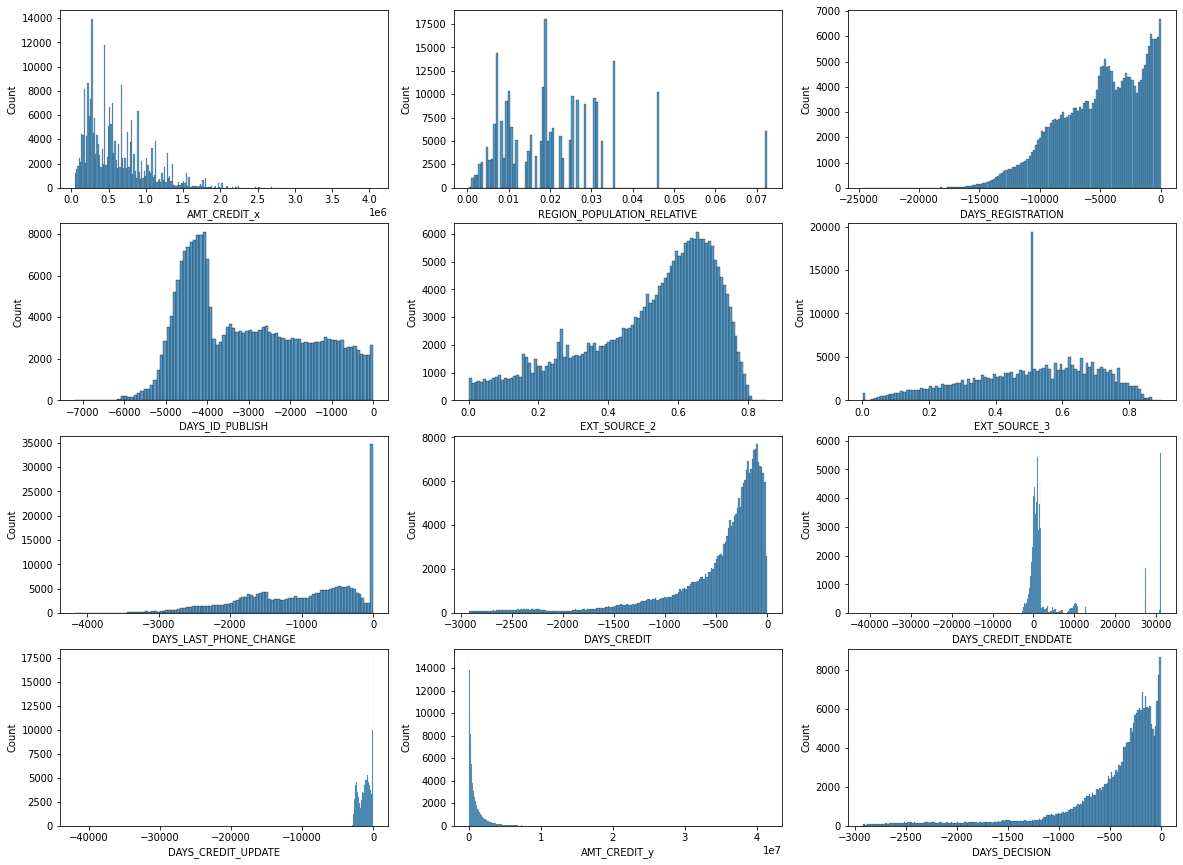

In [ ]:
plt.figure(figsize=(20,15))
for i,c in enumerate(["AMT_CREDIT_x", "REGION_POPULATION_RELATIVE","DAYS_REGISTRATION","DAYS_ID_PUBLISH","EXT_SOURCE_2",
                      "EXT_SOURCE_3","DAYS_LAST_PHONE_CHANGE","DAYS_CREDIT","DAYS_CREDIT_ENDDATE","DAYS_CREDIT_UPDATE",
                      "AMT_CREDIT_y","DAYS_DECISION"]):    
  plt.subplot(4,3,i+1)
  sns.histplot(application_train_bureau_previous[c], label=i)

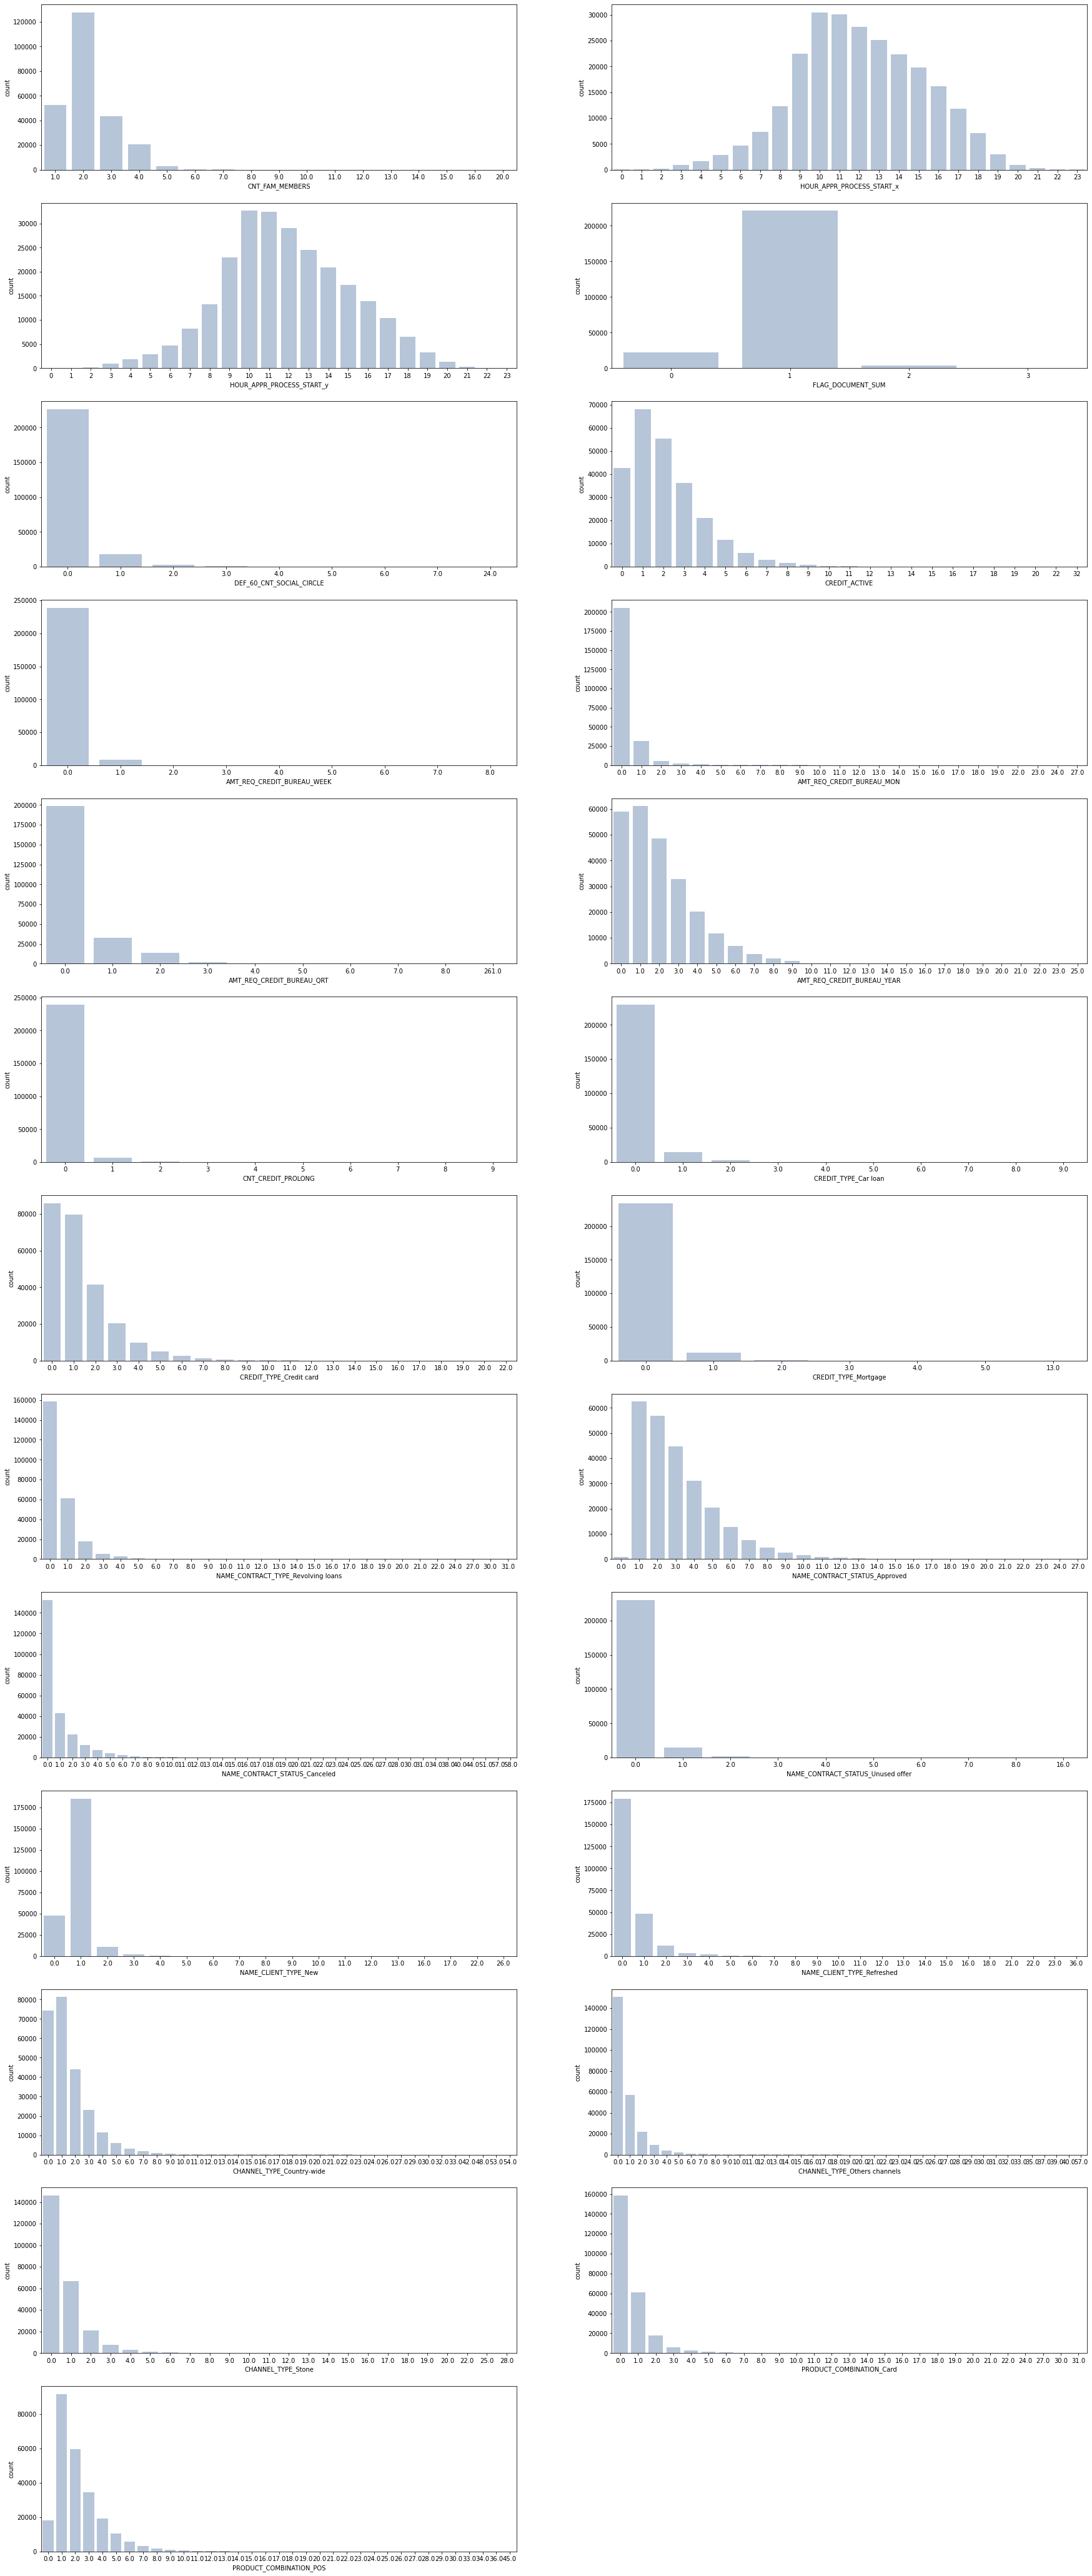

In [ ]:
# Variables cuantitativas discretas
plt.figure(figsize=(30,75))
for i,c in enumerate(["CNT_FAM_MEMBERS","HOUR_APPR_PROCESS_START_x","HOUR_APPR_PROCESS_START_y","FLAG_DOCUMENT_SUM","DEF_60_CNT_SOCIAL_CIRCLE","CREDIT_ACTIVE",
                      "AMT_REQ_CREDIT_BUREAU_WEEK","AMT_REQ_CREDIT_BUREAU_MON","AMT_REQ_CREDIT_BUREAU_QRT","AMT_REQ_CREDIT_BUREAU_YEAR","CNT_CREDIT_PROLONG",
                      "CREDIT_TYPE_Car loan","CREDIT_TYPE_Credit card","CREDIT_TYPE_Mortgage","NAME_CONTRACT_TYPE_Revolving loans",
                      "NAME_CONTRACT_STATUS_Approved","NAME_CONTRACT_STATUS_Canceled","NAME_CONTRACT_STATUS_Unused offer","NAME_CLIENT_TYPE_New",
                      "NAME_CLIENT_TYPE_Refreshed","CHANNEL_TYPE_Country-wide","CHANNEL_TYPE_Others channels","CHANNEL_TYPE_Stone","PRODUCT_COMBINATION_Card",
                      "PRODUCT_COMBINATION_POS"]):    
  plt.subplot(13,2,i+1)
  sns.countplot(x=application_train_bureau_previous[c], label=i, color="lightsteelblue")

La mayoría de las variables numéricas presentan un sesgo hacia una de las colas de la respectiva distribución, a excepción de las variables 'HOUR_APPR_PROCESS_START_x','HOUR_APPR_PROCESS_START_y' y 'EXT_SOURCE_3', las cuales muestran un comportamiento semejante a una distribución normal, evidenciando la mayor concentración de datos alrededor de la media.

Específicamente, las variables 'AMT_CREDIT_x' (Monto del crédito del préstamo) y 'REGION_POPULATION_RELATIVE' (Región relativa), presentan un sesgo hacia la derecha, donde los datos que presentan la mayor frecuencia son cercanos a valores mínimos de acuerdo con su respectivo rango.

Por otro lado, las variables 'DAYS_REGISTRATION' (Días antes de la solicitud en que el cliente cambió su registro) y 'EXT_SOURCE_2' (Puntuación de una fuente de datos externa), presentan un sesgo hacia la izquierda, atribuyendo la mayor frecuencia de datos a los valores máximos del rango.

La cantidad de miembros de la familia oscilan entre 1 y 5. Además, se observa que las horas en las que el cliente solicitó el préstamo transcurren entre las 10 y 12 horas aproximadamente, con un comportamiento normal.

**Variables categóricas**

Para analizar las variables categóricas del DataFrame se realizan diagramas de barras.

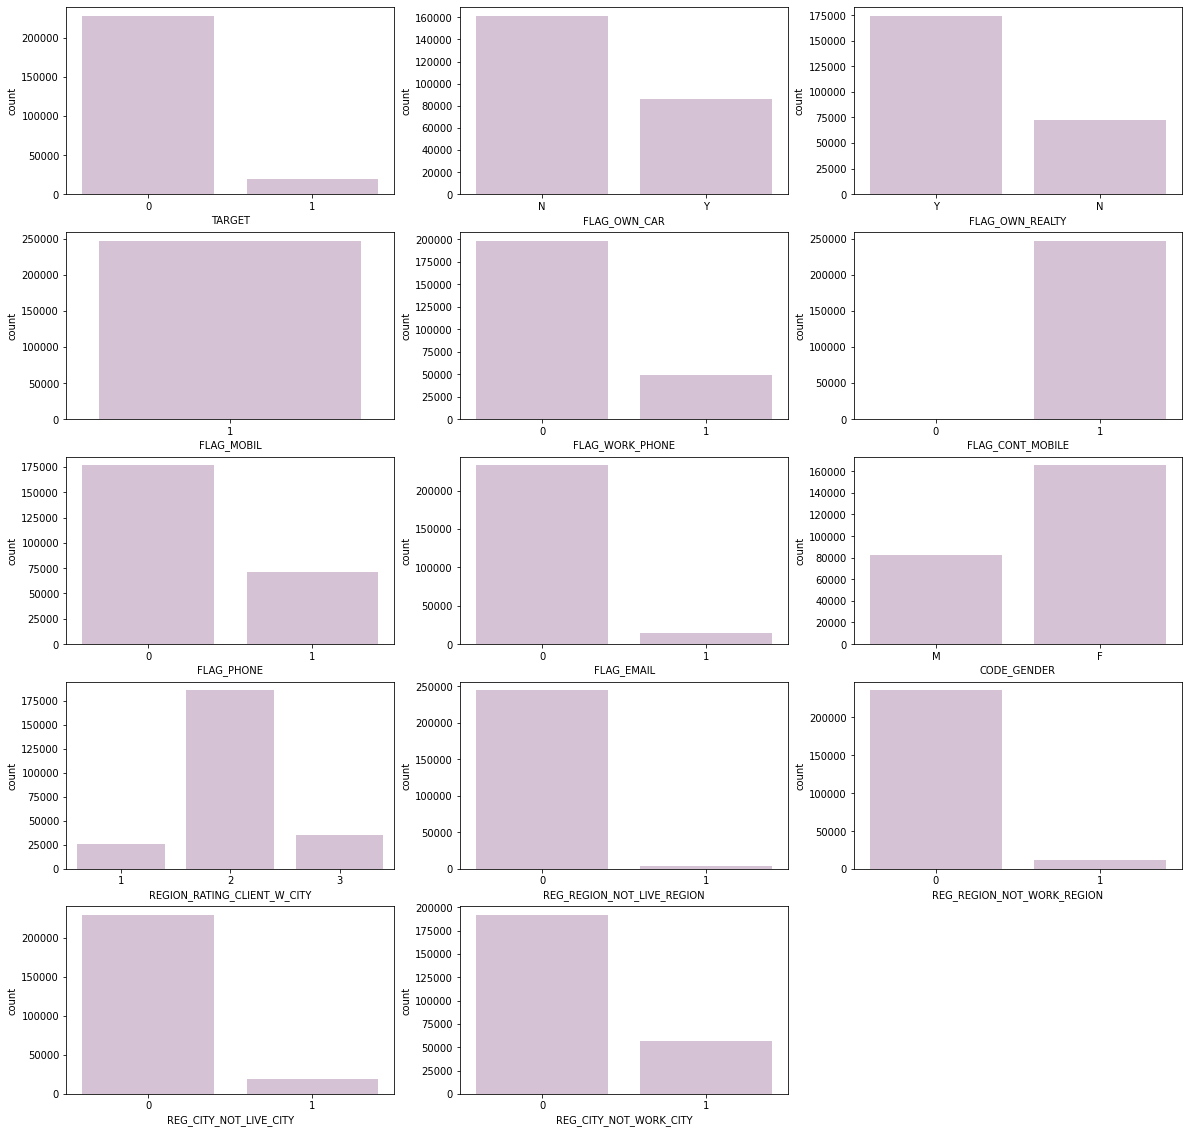

In [ ]:
# Variables categóricas con pocas clases
plt.figure(figsize=(20,20))
for i,c in enumerate(["TARGET","FLAG_OWN_CAR","FLAG_OWN_REALTY","FLAG_MOBIL","FLAG_WORK_PHONE","FLAG_CONT_MOBILE",
                      "FLAG_PHONE","FLAG_EMAIL","CODE_GENDER","REGION_RATING_CLIENT_W_CITY","REG_REGION_NOT_LIVE_REGION",
                      "REG_REGION_NOT_WORK_REGION","REG_CITY_NOT_LIVE_CITY","REG_CITY_NOT_WORK_CITY"]):    
  plt.subplot(5,3,i+1)
  sns.countplot(x=application_train_bureau_previous[c], label=i, color="thistle")

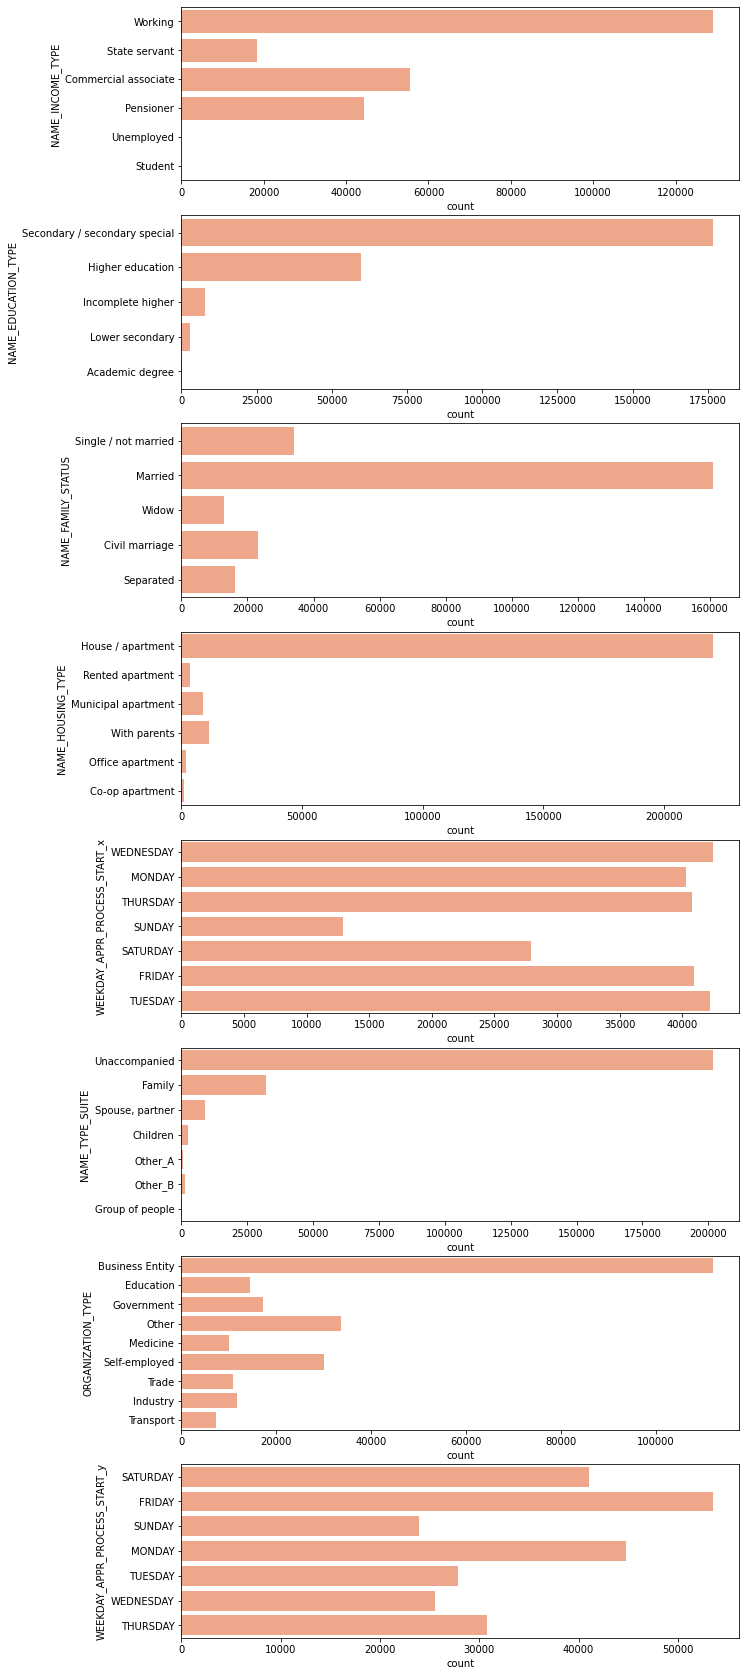

In [ ]:
# Variables categóricas con varias clases
plt.figure(figsize=(10,30))
for i,c in enumerate(["NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE",
                      "WEEKDAY_APPR_PROCESS_START_x","NAME_TYPE_SUITE","ORGANIZATION_TYPE","WEEKDAY_APPR_PROCESS_START_y"]):    
  plt.subplot(8,1,i+1)
  sns.countplot(y=application_train_bureau_previous[c], label=i, color="lightsalmon")

En la variable 'TARGET' se evidencia mayor predominancia de la categoría 0, la cual representa a los clientes que no se retrasan en sus pagos; por el contrario, los clientes que no cumplen las condiciones del préstamo (categoría 1) equivalen a menos de la décima parte de la categoría anterior.

También se observa que en el conjunto de datos, prevalecen los clientes con género femenino, sin vehículo propio y con al menos una propiedad raíz.  

Dentro de la calificación de la región donde vive el cliente (rango entre 1 y 3, prevalece la calificación 2, de modo general y también considerando la ciudad.




Se registra que la mayoría de los clientes se encuentran trabajando y su educación formal llega hasta nivel de secundaria. Por otro lado, la mayoría de los clientes están casados y viven en una casa o apartamento.

En cuanto a los días de la semana donde se atienden las solicitudes de préstamo, los días hábiles presentan frecuencias muy similares, mientras que hay una reducción del flujo en la atención los días sábados y domingos.

Se encuentra que la mayoría de personas que acuden a los préstamos trabajan como personal de Business Entity.

### ANÁLISIS BIVARIABLE

En el análisis bivariable se comparan todas las variables con respecto al TARGET o variable objetivo, para validar si existe un comportamiento notorio o una correlación entre cada par de variables.

**Variables numéricas**

Para analizar las variables numéricas con el TARGET se utilizan diagramas de barras.

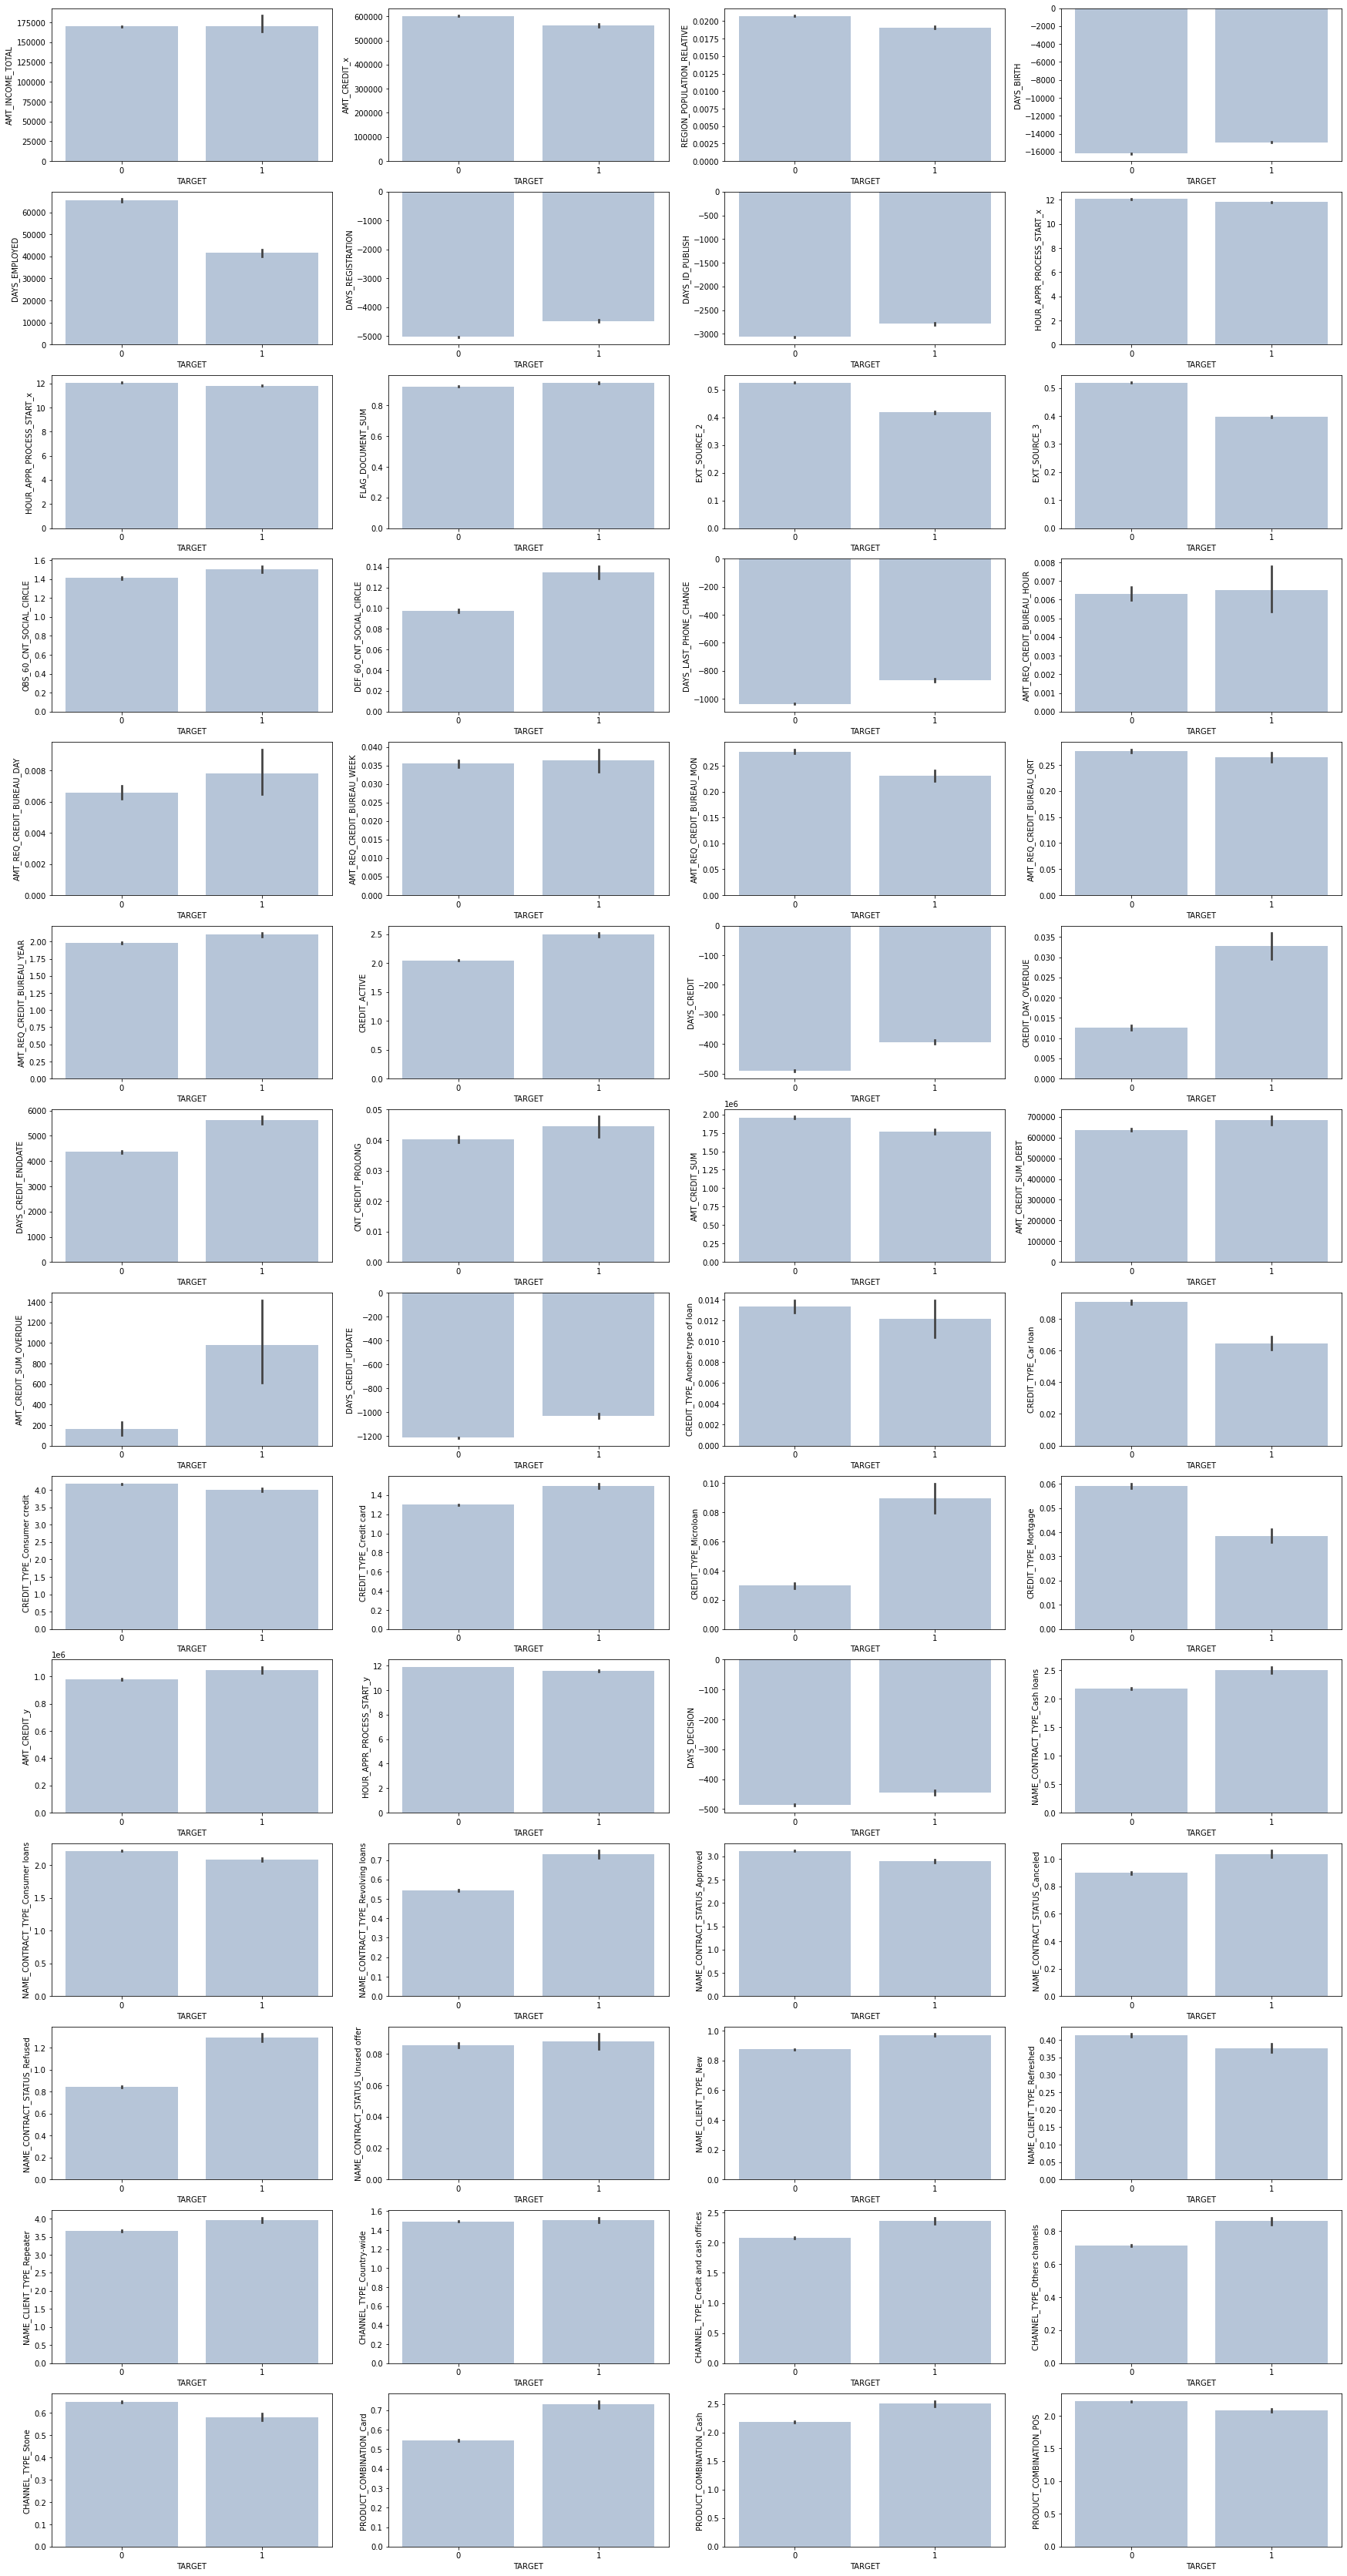

In [ ]:
plt.figure(figsize=(30,65))
for i,c in enumerate(["AMT_INCOME_TOTAL","AMT_CREDIT_x", "REGION_POPULATION_RELATIVE", "DAYS_BIRTH","DAYS_EMPLOYED","DAYS_REGISTRATION",
        "DAYS_ID_PUBLISH","HOUR_APPR_PROCESS_START_x", "HOUR_APPR_PROCESS_START_x","FLAG_DOCUMENT_SUM","EXT_SOURCE_2",   
        "EXT_SOURCE_3", "OBS_60_CNT_SOCIAL_CIRCLE","DEF_60_CNT_SOCIAL_CIRCLE","DAYS_LAST_PHONE_CHANGE",
        "AMT_REQ_CREDIT_BUREAU_HOUR","AMT_REQ_CREDIT_BUREAU_DAY","AMT_REQ_CREDIT_BUREAU_WEEK","AMT_REQ_CREDIT_BUREAU_MON",
        "AMT_REQ_CREDIT_BUREAU_QRT","AMT_REQ_CREDIT_BUREAU_YEAR","CREDIT_ACTIVE","DAYS_CREDIT","CREDIT_DAY_OVERDUE",
        "DAYS_CREDIT_ENDDATE","CNT_CREDIT_PROLONG","AMT_CREDIT_SUM","AMT_CREDIT_SUM_DEBT","AMT_CREDIT_SUM_OVERDUE",
        "DAYS_CREDIT_UPDATE","CREDIT_TYPE_Another type of loan","CREDIT_TYPE_Car loan","CREDIT_TYPE_Consumer credit",
        "CREDIT_TYPE_Credit card","CREDIT_TYPE_Microloan","CREDIT_TYPE_Mortgage","AMT_CREDIT_y","HOUR_APPR_PROCESS_START_y",
        "DAYS_DECISION","NAME_CONTRACT_TYPE_Cash loans","NAME_CONTRACT_TYPE_Consumer loans","NAME_CONTRACT_TYPE_Revolving loans",
        "NAME_CONTRACT_STATUS_Approved","NAME_CONTRACT_STATUS_Canceled","NAME_CONTRACT_STATUS_Refused",
        "NAME_CONTRACT_STATUS_Unused offer","NAME_CLIENT_TYPE_New","NAME_CLIENT_TYPE_Refreshed","NAME_CLIENT_TYPE_Repeater",
        "CHANNEL_TYPE_Country-wide","CHANNEL_TYPE_Credit and cash offices","CHANNEL_TYPE_Others channels","CHANNEL_TYPE_Stone",
        "PRODUCT_COMBINATION_Card","PRODUCT_COMBINATION_Cash","PRODUCT_COMBINATION_POS"]):    
    plt.subplot(15,4,i+1)
    sns.barplot(data=application_train_bureau_previous,x=application_train_bureau_previous["TARGET"],y=application_train_bureau_previous[c], color="lightsteelblue")
    plt.xticks([0,1])

La mayoría de variables numéricas presentan una frecuencia muy semejante entre los clientes con TARGET 1 (cliente con dificultades de pago) y TARGET 0 (cliente cumplido).

Sin embargo, se observa diferencias significativas en algunas de las variables, como es el caso de 'DAYS_EMPLOYED' que presenta una frecuencia máxima de 40000 para clientes con dificultades de pago, mientras que para los clientes cumplidos asciende a más de 60000; es decir que cuentan con mayor cantidad de días trabajando antes de presentar la solicitud presentan mayor estabilidad económica para cumplir con las responsabilidades financieras.

Igualmente, se observa que los clientes cumplidos en sus pagos (TARGET 0) presentan una mayor puntuación en entidades crediticias externas, aproximadamente de 0.5 para las variables 'EXT_SOURCE_2' y 'EXT_SOURCE_3'; mientras que los clientes con dificultades de pago presentan una puntuación de 0.4 para las mismas variables.

Ahora, la variable 'DEF_60_CNT_SOCIAL_CIRCLE' que muestra la cantidad de observaciones del entorno social del cliente con un incumplimiento de 60 días de atraso, evidencia que los clientes con cumplimiento en sus obligaciones presentan una menor cantidad de observaciones de incumplimiento en su círculo social, con respecto a los clientes con dificultades de pago.

También se observa que los clientes cumplidos (TARGET 0) presentan menos del 50% de días de atraso del crédito en Bureau en el momento de la solicitud, con relación a los clientes con dificultades de pago que presentan más días de atraso en Bureau. Y similarmente, se presenta el mismo comportamiento con la variable que representa el monto actual atrasado de los créditos Bureau para cada cliente; en este caso el monto atrasado en Bureau es cinco veces mayor para los clientes que tienen dificultades de pago en el crédito de Home Credit.

**Variables categóricas**

Para el análisis de las variables categóricas en relación con el TARGET, se utilizan diagramas de distribución de densidad, acompañados de diagramas de barras con las diferentes categorías asociadas a cada variable.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

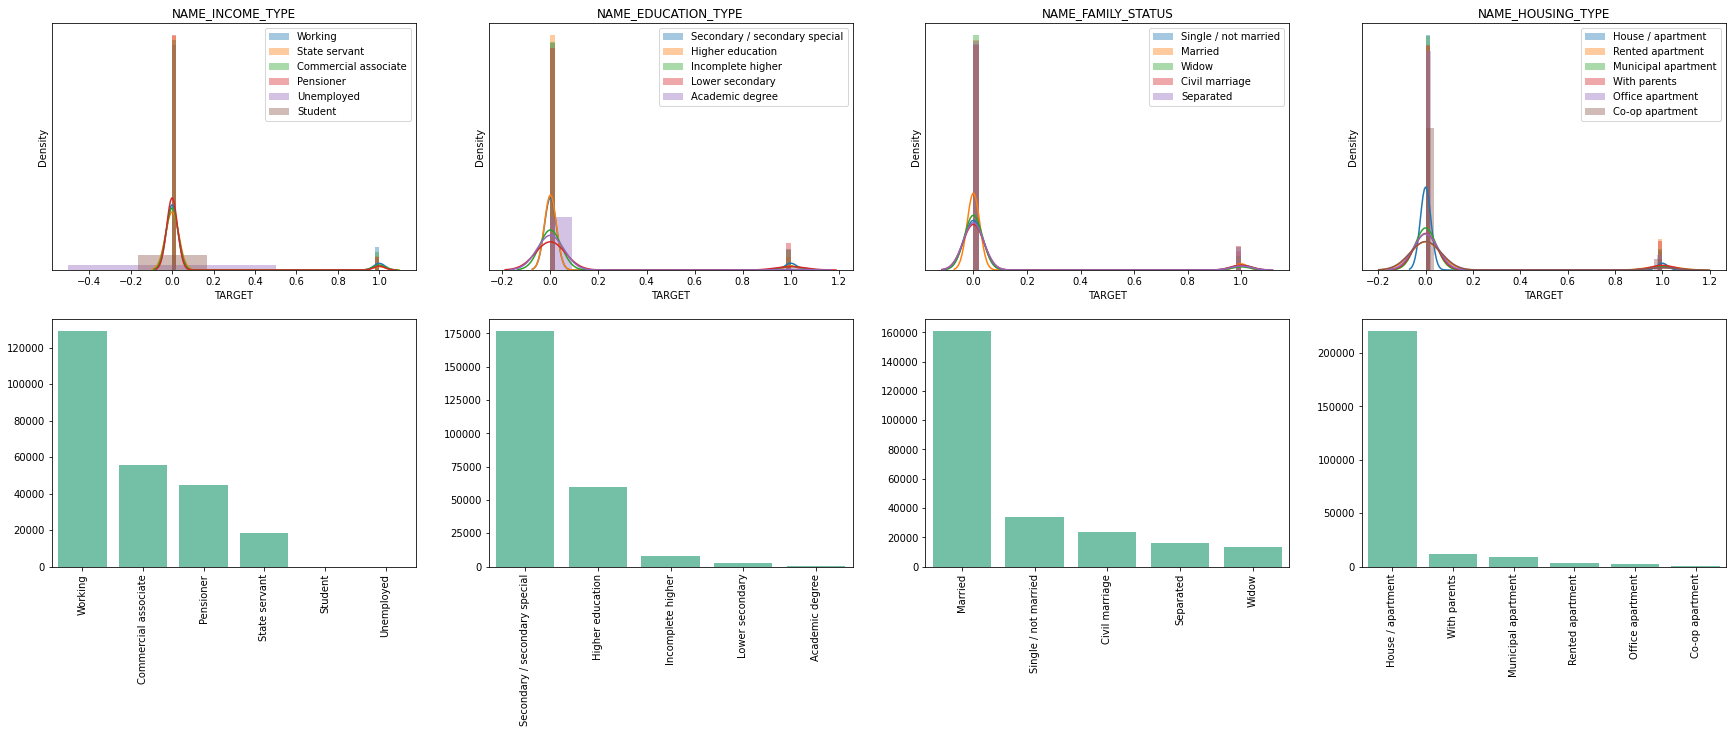

In [ ]:
plt.figure(figsize=(30,10))
for i,c in enumerate(["NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE"]):    
    plt.subplot(2,4,i+1)
    k=application_train_bureau_previous[[c,"TARGET"]].dropna()
    for v in application_train_bureau_previous[c].dropna().unique():
        sns.distplot(k.TARGET[k[c]==v],label=v);
        plt.title(c)
    plt.yticks([])
    plt.legend()
    plt.subplot(2,4,i+5)
    vc = k[c].value_counts()
    sns.barplot(vc.index, vc.values,color="mediumaquamarine")    
    plt.xticks(range(len(vc)), vc.index, rotation="vertical")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

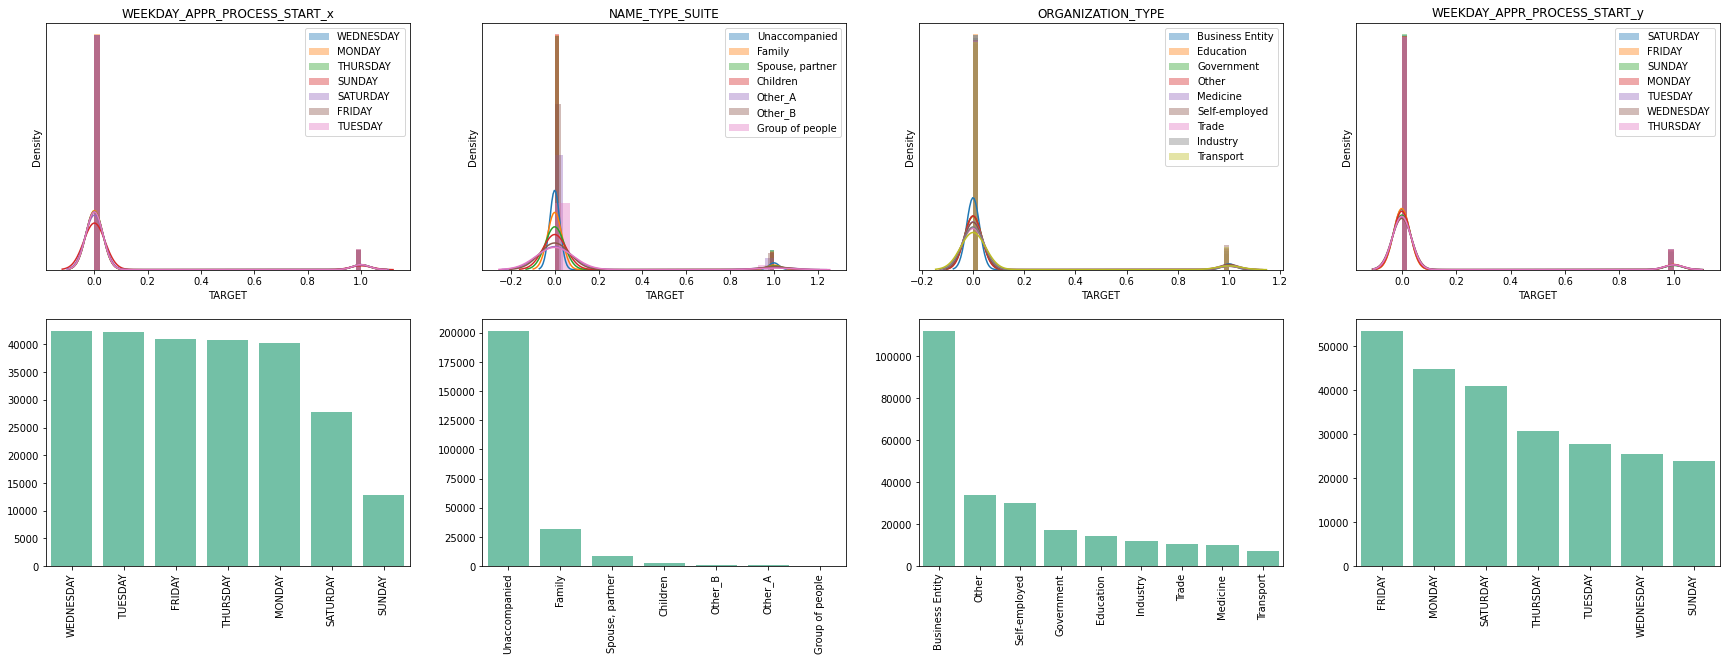

In [ ]:
plt.figure(figsize=(30,10))
for i,c in enumerate(["WEEKDAY_APPR_PROCESS_START_x","NAME_TYPE_SUITE","ORGANIZATION_TYPE","WEEKDAY_APPR_PROCESS_START_y"]):    
    plt.subplot(2,4,i+1)
    k=application_train_bureau_previous[[c,"TARGET"]].dropna()
    for v in application_train_bureau_previous[c].dropna().unique():
        sns.distplot(k.TARGET[k[c]==v],label=v);
        plt.title(c)
    plt.yticks([])
    plt.legend()
    plt.subplot(2,4,i+5)
    vc = k[c].value_counts()
    sns.barplot(vc.index, vc.values,color="mediumaquamarine")    
    plt.xticks(range(len(vc)), vc.index, rotation="vertical")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpret

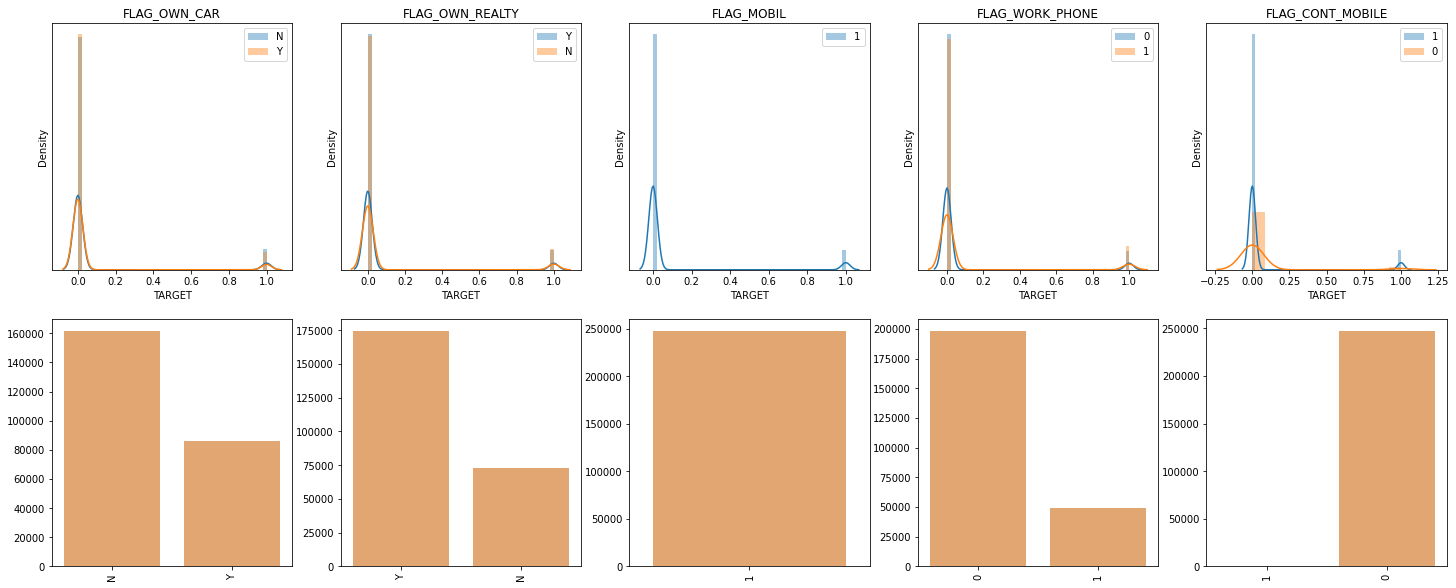

In [ ]:
plt.figure(figsize=(25,10))
for i,c in enumerate(["FLAG_OWN_CAR","FLAG_OWN_REALTY","FLAG_MOBIL","FLAG_WORK_PHONE","FLAG_CONT_MOBILE"]):    
    plt.subplot(2,5,i+1)
    k=application_train_bureau_previous[[c,"TARGET"]].dropna()
    for v in application_train_bureau_previous[c].dropna().unique():
        sns.distplot(k.TARGET[k[c]==v], label=v);
        plt.title(c)
    plt.yticks([])
    plt.legend()
    plt.subplot(2,5,i+6)
    vc = k[c].value_counts()
    sns.barplot(vc.index, vc.values,color="sandybrown")    
    plt.xticks(range(len(vc)), vc.index, rotation="vertical")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpret

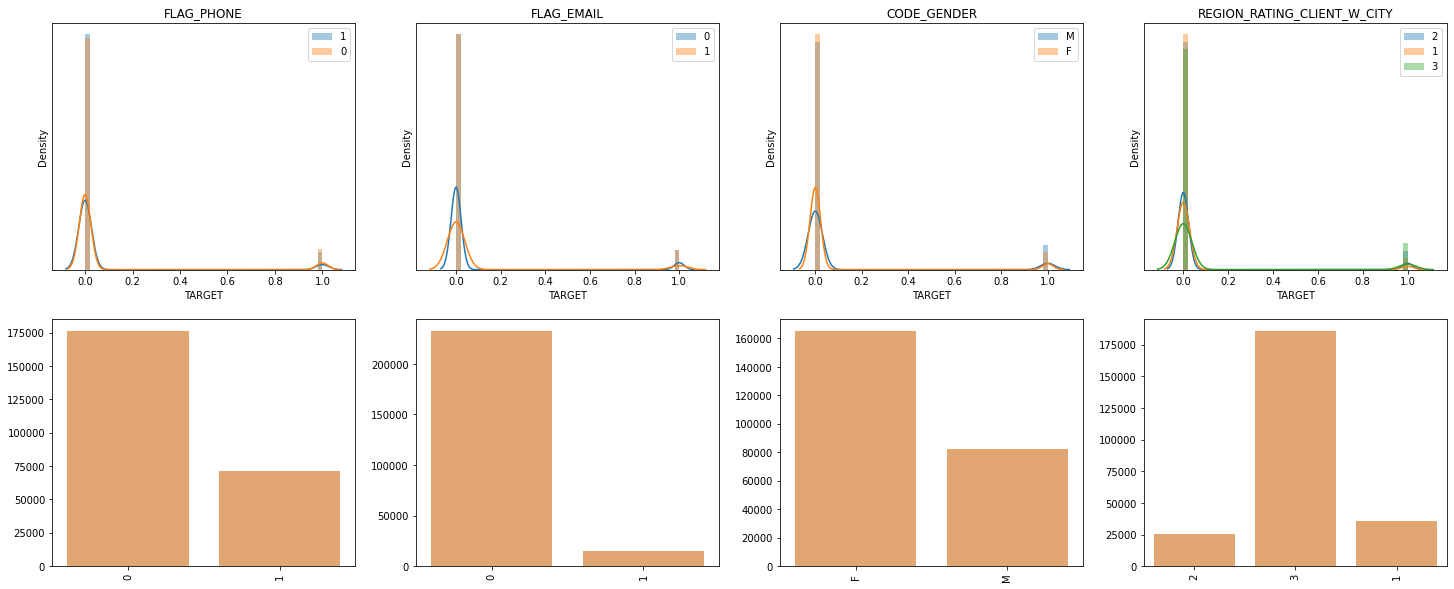

In [ ]:
plt.figure(figsize=(25,10))
for i,c in enumerate(["FLAG_PHONE","FLAG_EMAIL","CODE_GENDER","REGION_RATING_CLIENT_W_CITY"]):    
    plt.subplot(2,4,i+1)
    k=application_train_bureau_previous[[c,"TARGET"]].dropna()
    for v in application_train_bureau_previous[c].dropna().unique():
        sns.distplot(k.TARGET[k[c]==v], label=v);
        plt.title(c)
    plt.yticks([])
    plt.legend()
    plt.subplot(2,4,i+5)
    vc = k[c].value_counts()
    sns.barplot(vc.index, vc.values,color="sandybrown")    
    plt.xticks(range(len(vc)), vc.index, rotation="vertical")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpret

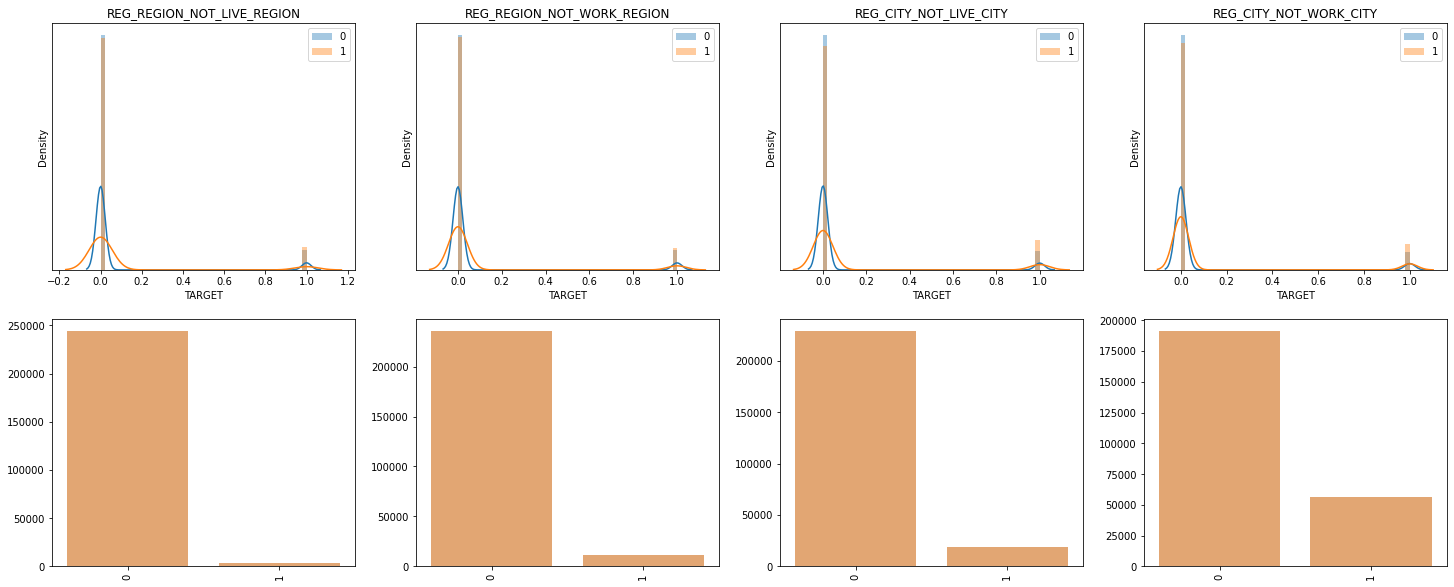

In [ ]:
plt.figure(figsize=(25,10))
for i,c in enumerate(["REG_REGION_NOT_LIVE_REGION","REG_REGION_NOT_WORK_REGION","REG_CITY_NOT_LIVE_CITY","REG_CITY_NOT_WORK_CITY"]):    
    plt.subplot(2,4,i+1)
    k=application_train_bureau_previous[[c,"TARGET"]].dropna()
    for v in application_train_bureau_previous[c].dropna().unique():
        sns.distplot(k.TARGET[k[c]==v], label=v);
        plt.title(c)
    plt.yticks([])
    plt.legend()
    plt.subplot(2,4,i+5)
    vc = k[c].value_counts()
    sns.barplot(vc.index, vc.values,color="sandybrown")    
    plt.xticks(range(len(vc)), vc.index, rotation="vertical")

En la mayoría de gráficas se evidencia que el comportamiento de las categorías con mayor frecuencia en las variables categóricas se mantiene tanto para clientes con TARGET 0 como con TARGET 1, siendo coherente con la categoría de mayor frecuencia en el TARGET, es decir, 0 para representar el cumplimiento del cliente. 

Particularmente, se observa que las personas pensionadas presentan un mayor comportamiento de pago oportuno del préstamo, frente a las diferentes ocupaciones de los clientes.

También se observa que en cuanto a la educación, los clientes con cumplimiento tienen educación superior, mientras que los clientes con dificultades de pago en su mayoría solo llegan a nivel de secundaria.

Para la variable 'FLAG_MOBIL' que indica si el cliente proporcionó un teléfono móvil, se evidencia que todos los clientes proporcionaron esta información, independientemente de su nivel de cumplimiento.

# PROCESO DE ANALÍTICA

## PREPROCESAMIENTO

**Tratamiento de duplicados**

Para el tratamiento de duplicados, se utiliza inicialmente el método 'duplicated()' para identificar si hay presencia de registros duplicados. En este caso se observa que la suma de duplicados es cero, es decir que no presentan registros duplicados en la tabla.

In [ ]:
application_train_bureau_previous.duplicated().sum()

0

**Tratamiento de datos nulos**

Para realizar el tratamiento de datos nulos, se realiza una suma de los valores nulos, y se detecta que no hay datos nulos porque éstos fueron tratados previamente a la unión de tablas.

Adicionalmente, se encuentran variables con su mayoría de registros equivalentes a una misma clase, lo cual sugiere que no aportará información relevante al modelo. Por lo cual, a continuación se eliminan las variables que contengan el 95% de sus registros asociados a una misma clase.

In [ ]:
# Conteo de nulos diferentes a 0 por cada variable
null_application_train_bureau_previous = application_train_bureau_previous.isna().sum()
Nulos_application_train_bureau_previous=null_application_train_bureau_previous[null_application_train_bureau_previous!=0]
Nulos_application_train_bureau_previous

Series([], dtype: int64)

In [ ]:
# El 99,9% de sus clases corresponde a un valor=1
freq_FLAG_CONT_MOBILE=application_train_bureau_previous['FLAG_CONT_MOBILE'].value_counts() 
print(freq_FLAG_CONT_MOBILE)

1    247245
0       163
Name: FLAG_CONT_MOBILE, dtype: int64


In [ ]:
# El 98,6% de sus clases corresponde a un valor=0
freq_REG_REGION_NOT_LIVE_REGION=application_train_bureau_previous['REG_REGION_NOT_LIVE_REGION'].value_counts() 
print(freq_REG_REGION_NOT_LIVE_REGION)

0    244020
1      3388
Name: REG_REGION_NOT_LIVE_REGION, dtype: int64


In [ ]:
# El 95,1% de sus clases corresponde a un valor=0
freq_REG_REGION_NOT_WORK_REGION=application_train_bureau_previous['REG_REGION_NOT_WORK_REGION'].value_counts() 
print(freq_REG_REGION_NOT_WORK_REGION)

0    235487
1     11921
Name: REG_REGION_NOT_WORK_REGION, dtype: int64


In [ ]:
# El 99,3% de sus clases corresponde a un valor=0
freq_AMT_REQ_CREDIT_BUREAU_HOUR=application_train_bureau_previous['AMT_REQ_CREDIT_BUREAU_HOUR'].value_counts() 
print(freq_AMT_REQ_CREDIT_BUREAU_HOUR)

0.0    245910
1.0      1442
2.0        47
3.0         8
4.0         1
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: int64


In [ ]:
# El 99,4% de sus clases corresponde a un valor=0
freq_AMT_REQ_CREDIT_BUREAU_DAY=application_train_bureau_previous['AMT_REQ_CREDIT_BUREAU_DAY'].value_counts() 
print(freq_AMT_REQ_CREDIT_BUREAU_DAY)

0.0    246049
1.0      1201
2.0        86
3.0        38
4.0        19
5.0         7
6.0         6
9.0         2
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: int64


In [ ]:
# El 96,6% de sus clases corresponde a un valor=0
freq_AMT_REQ_CREDIT_BUREAU_WEEK=application_train_bureau_previous['AMT_REQ_CREDIT_BUREAU_WEEK'].value_counts() 
print(freq_AMT_REQ_CREDIT_BUREAU_WEEK)

0.0    239130
1.0      7998
2.0       173
3.0        49
4.0        29
6.0        15
5.0         8
8.0         5
7.0         1
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: int64


In [ ]:
# El 98,7% de sus clases corresponde a un valor=0
freq_CREDIT_DAY_OVERDUE=application_train_bureau_previous['CREDIT_DAY_OVERDUE'].value_counts() 
print(freq_CREDIT_DAY_OVERDUE)

0    244188
1      3015
2       152
3        36
4        10
5         4
6         2
7         1
Name: CREDIT_DAY_OVERDUE, dtype: int64


In [ ]:
# El 96,7% de sus clases corresponde a un valor=0
freq_CNT_CREDIT_PROLONG=application_train_bureau_previous['CNT_CREDIT_PROLONG'].value_counts() 
print(freq_CNT_CREDIT_PROLONG)

0    239417
1      6452
2      1206
3       240
4        55
5        28
6         6
9         2
8         1
7         1
Name: CNT_CREDIT_PROLONG, dtype: int64


In [ ]:
# El 98,8% de sus clases corresponde a un valor=0
freq_CREDIT_TYPE_Another_type_of_loan=application_train_bureau_previous['CREDIT_TYPE_Another type of loan'].value_counts() 
print(freq_CREDIT_TYPE_Another_type_of_loan)

0.0     244618
1.0       2458
2.0        242
3.0         57
4.0         21
5.0          7
6.0          2
10.0         1
7.0          1
8.0          1
Name: CREDIT_TYPE_Another type of loan, dtype: int64


In [ ]:
# El 98,6% de sus clases corresponde a un valor=0
freq_CREDIT_TYPE_Microloan=application_train_bureau_previous['CREDIT_TYPE_Microloan'].value_counts() 
print(freq_CREDIT_TYPE_Microloan)

0.0     244108
1.0       1771
2.0        595
3.0        297
4.0        188
5.0        119
6.0         81
7.0         49
8.0         37
9.0         36
10.0        24
11.0        24
12.0        14
13.0        12
15.0        10
18.0         8
16.0         7
20.0         6
14.0         6
17.0         3
23.0         2
19.0         2
22.0         2
25.0         1
79.0         1
44.0         1
40.0         1
21.0         1
24.0         1
28.0         1
Name: CREDIT_TYPE_Microloan, dtype: int64


In [ ]:
# Las siguientes variables tienen una clase que predomina en más un 95% sobre el total de los registros
application_train_bureau_previous.drop(["FLAG_MOBIL","FLAG_CONT_MOBILE","REG_REGION_NOT_LIVE_REGION","REG_REGION_NOT_WORK_REGION","AMT_REQ_CREDIT_BUREAU_HOUR","AMT_REQ_CREDIT_BUREAU_DAY","AMT_REQ_CREDIT_BUREAU_WEEK","CREDIT_DAY_OVERDUE","CNT_CREDIT_PROLONG","CREDIT_TYPE_Another type of loan","CREDIT_TYPE_Microloan"],axis="columns", inplace=True)

**Correlación de variables**

Adicionalmente, se realizó la matriz de correlación para validar cuáles variables aportan la misma información al problema, considerando así, eliminar aquellas con una correlación mayor al 70%.

In [ ]:
# Matriz de correlación
Matriz_Correlacion_application_train_bureau_previous = application_train_bureau_previous.corr(method='pearson')
Matriz_Correlacion_application_train_bureau_previous

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_x,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_SUM,EXT_SOURCE_2,EXT_SOURCE_3,CNT_FAM_MEMBERS,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Mortgage,SK_ID_PREV,AMT_CREDIT_y,HOUR_APPR_PROCESS_START_y,DAYS_DECISION,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Others channels,CHANNEL_TYPE_Stone,PRODUCT_COMBINATION_Card,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_POS
SK_ID_CURR,1.000000,-0.003360,-0.001338,-0.001516,-0.000469,-0.002698,0.002209,-0.000761,-0.000384,0.000633,0.003737,0.000335,-0.000996,0.000763,-0.001733,-0.001854,-0.001780,0.002351,0.000922,-0.003280,-0.001557,0.001325,0.000118,0.000899,0.000782,0.003675,0.001680,0.001038,0.004439,0.001392,0.004138,0.000164,-0.000004,0.002051,0.005285,0.000300,0.003058,-0.000054,0.003024,0.002342,0.002688,0.001368,0.001524,0.003104,0.001957,0.001406,0.002359,0.002891,0.001021,0.002493,-0.001827,0.003044,0.001677,0.002468,0.001030,0.000303,0.001957,0.001524,0.003104
TARGET,-0.003360,1.000000,0.000366,-0.027178,-0.033025,0.079115,-0.045443,0.041639,0.050133,0.026439,-0.023881,-0.000524,0.056663,-0.020866,0.043090,0.049180,0.019287,-0.152505,-0.172537,0.011582,0.010426,0.027381,0.055820,-0.013751,-0.003896,0.017283,0.002415,0.066629,0.049055,0.036175,-0.012585,0.007488,0.013002,0.043937,-0.020028,-0.012943,0.035011,-0.021661,0.023806,0.011644,-0.024353,0.019349,0.026499,-0.019658,0.048674,-0.027123,0.021893,0.065237,0.002064,0.045034,-0.011305,0.019907,0.002293,0.022762,0.029173,-0.017872,0.048674,0.026499,-0.019658
AMT_INCOME_TOTAL,-0.001338,0.000366,1.000000,0.135728,0.062563,0.026287,-0.058191,0.024398,0.012407,-0.016360,-0.001429,0.037387,-0.080887,0.029977,0.005247,0.008320,0.019792,0.050889,-0.031548,0.013529,-0.009733,-0.010748,-0.019787,0.024637,0.005626,0.017389,0.048338,0.057153,0.018467,0.033459,0.117094,0.098977,-0.000390,-0.010025,0.083575,0.025289,0.055307,0.040229,0.025878,0.072589,0.033432,0.010276,0.026118,0.004812,0.014066,0.015091,0.020669,0.020914,0.007807,-0.005878,0.003944,0.025640,0.015065,0.034652,-0.002774,-0.026398,0.014066,0.026118,0.004812
AMT_CREDIT_x,-0.001516,-0.027178,0.135728,1.000000,0.093438,-0.056499,-0.063132,0.006511,0.001088,-0.018333,0.024539,0.018685,-0.103627,0.045402,-0.025323,-0.016012,0.229504,0.123323,0.040199,0.063687,0.003351,-0.022164,-0.091358,0.058582,0.021073,-0.032831,0.065833,0.047389,-0.010583,0.021891,0.143327,0.098464,-0.003791,-0.053378,0.105055,0.038180,0.078209,0.043485,-0.018722,0.106362,0.040487,-0.045087,-0.016269,0.002948,-0.030309,0.013241,-0.019155,-0.038826,-0.008611,-0.063944,0.000737,-0.010125,-0.002099,-0.009713,-0.019153,-0.016397,-0.030309,-0.016269,0.002948
REGION_POPULATION_RELATIVE,-0.000469,-0.033025,0.062563,0.093438,1.000000,-0.029008,-0.006053,-0.050777,-0.003400,-0.015802,0.087496,0.042663,-0.516730,0.161065,-0.046982,-0.037474,-0.002552,0.191129,-0.009466,-0.021437,-0.004686,0.005635,-0.053729,0.080612,0.001809,0.013483,-0.033516,-0.013198,-0.033349,0.033090,0.045803,0.037652,-0.000215,0.020674,0.067888,-0.064528,0.043693,-0.013992,0.007318,0.050571,0.165272,-0.019072,0.020747,-0.025219,0.009134,0.003310,0.004549,0.005483,0.0170

Las variables que serán eliminadas por presentar una correlación mayor al 70% con alguna otra variable son: "PRODUCT_COMBINATION_POS", "CHANNEL_TYPE_Credit and cash offices", "NAME_CONTRACT_TYPE_Consumer loans", "NAME_CLIENT_TYPE_Repeater", "CREDIT_TYPE_Credit card", "NAME_CONTRACT_TYPE_Cash loans" y "PRODUCT_COMBINATION_Cash".


Por otro lado, la variable "FLAG_MOBIL" cuenta con una sola clase equivalente a 1, por lo cual no aporta información al problema.

In [ ]:
# Se eliminan las siguientes variables por correlación mayor al 70% con algún otra variable.
application_train_bureau_previous.drop(["PRODUCT_COMBINATION_POS","CHANNEL_TYPE_Credit and cash offices","NAME_CONTRACT_TYPE_Consumer loans","NAME_CLIENT_TYPE_Repeater","CREDIT_TYPE_Credit card","NAME_CONTRACT_TYPE_Cash loans","PRODUCT_COMBINATION_Cash"],axis="columns", inplace=True)

In [ ]:
# Cantidad de columnas después de correlación
application_train_bureau_previous.shape

(247408, 64)

**Tratamiento de outliers**

Para el tratamiento de outliers, inicialmente se grafican los boxplot de todas las variables numéricas, con el fin de identificar visualmente los valores atípicos en las distribuciones de los datos. Posteriormente se utiliza la técnica LOF para eliminar los outliers, variando el número de vecinos para identificar aquel con mayor capacidad para eliminar los outliers (se varía entre 3, 5, 7 y 9 número de vecinos). Finalmente, se vuelven a graficar las distribuciones de las variables a través de diagramas de cajas para visualizar la disminución de dichos datos atípicos.

In [ ]:
df_numeric=application_train_bureau_previous.select_dtypes(include=['int64','float64'])
df_numeric.columns

Index(['SK_ID_CURR', 'TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'REGION_RATING_CLIENT_W_CITY',
       'HOUR_APPR_PROCESS_START_x', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_SUM', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'CNT_FAM_MEMBERS', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE',
       'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE',
       'CREDIT_TYPE_Car loan', 'CREDIT_TYPE_Consumer credit',
       'CREDIT_TYPE_Mortgage', 'SK_ID_PREV', 'AMT_CREDIT_y',
       'HOUR_APPR_PROCESS_START_y', 'DAYS_DECISION',
       'NAME_CONTR

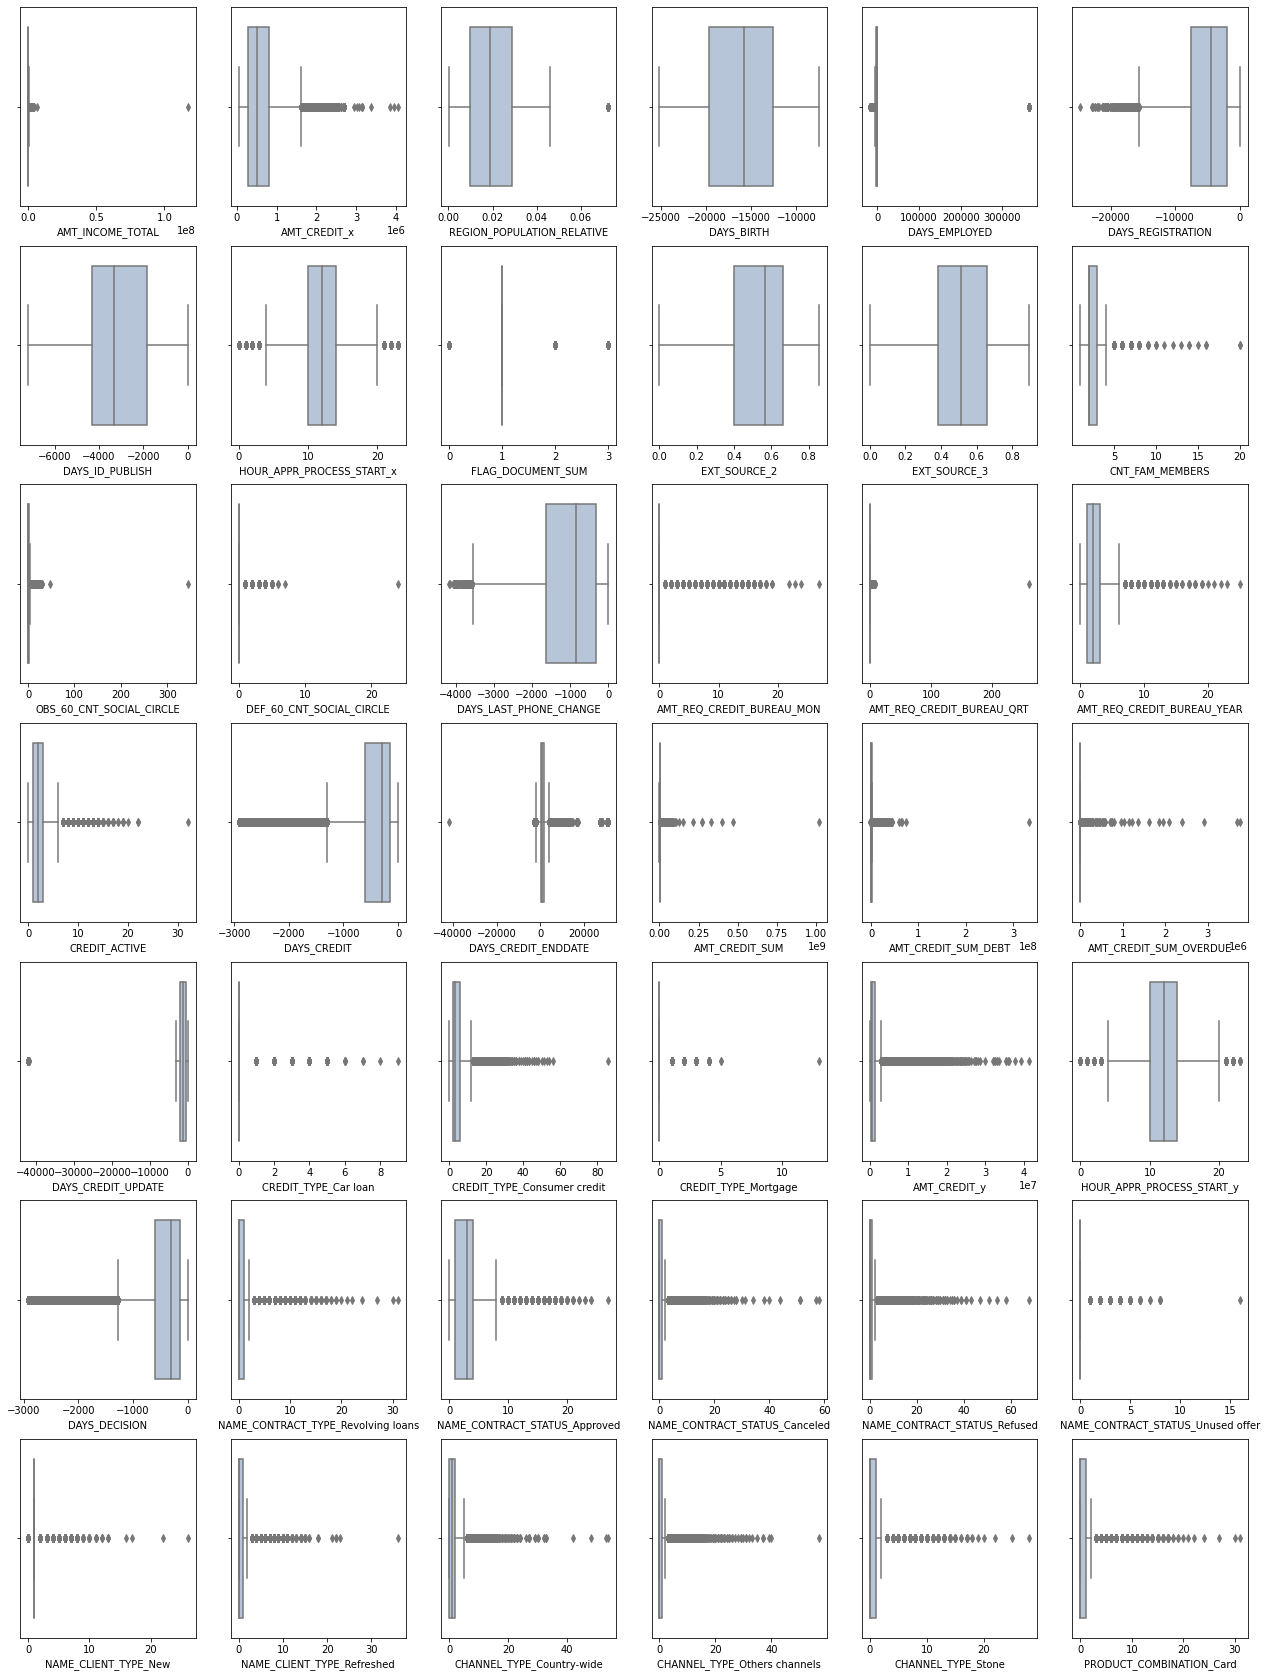

In [ ]:
plt.figure(figsize=(22,30))
for i,c in enumerate(['AMT_INCOME_TOTAL', 'AMT_CREDIT_x','REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED','DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
                      'HOUR_APPR_PROCESS_START_x', 'FLAG_DOCUMENT_SUM', 'EXT_SOURCE_2','EXT_SOURCE_3', 'CNT_FAM_MEMBERS', 'OBS_60_CNT_SOCIAL_CIRCLE',
                      'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE','AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR',
                      'CREDIT_ACTIVE','DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE', 
                      'DAYS_CREDIT_UPDATE','CREDIT_TYPE_Car loan', 'CREDIT_TYPE_Consumer credit','CREDIT_TYPE_Mortgage', 'AMT_CREDIT_y',
                      'HOUR_APPR_PROCESS_START_y', 'DAYS_DECISION','NAME_CONTRACT_TYPE_Revolving loans', 'NAME_CONTRACT_STATUS_Approved',
                      'NAME_CONTRACT_STATUS_Canceled', 'NAME_CONTRACT_STATUS_Refused','NAME_CONTRACT_STATUS_Unused offer', 'NAME_CLIENT_TYPE_New',
                      'NAME_CLIENT_TYPE_Refreshed', 'CHANNEL_TYPE_Country-wide','CHANNEL_TYPE_Others channels', 'CHANNEL_TYPE_Stone','PRODUCT_COMBINATION_Card']):    
  plt.subplot(7,6,i+1)
  sns.boxplot(x=application_train_bureau_previous[c], color="lightsteelblue")

In [ ]:
variables_num=application_train_bureau_previous[['AMT_INCOME_TOTAL', 'AMT_CREDIT_x','REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED','DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
                      'HOUR_APPR_PROCESS_START_x', 'FLAG_DOCUMENT_SUM', 'EXT_SOURCE_2','EXT_SOURCE_3', 'CNT_FAM_MEMBERS', 'OBS_60_CNT_SOCIAL_CIRCLE',
                      'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE','AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR',
                      'CREDIT_ACTIVE','DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE', 
                      'DAYS_CREDIT_UPDATE','CREDIT_TYPE_Car loan', 'CREDIT_TYPE_Consumer credit','CREDIT_TYPE_Mortgage', 'AMT_CREDIT_y',
                      'HOUR_APPR_PROCESS_START_y', 'DAYS_DECISION','NAME_CONTRACT_TYPE_Revolving loans', 'NAME_CONTRACT_STATUS_Approved',
                      'NAME_CONTRACT_STATUS_Canceled', 'NAME_CONTRACT_STATUS_Refused','NAME_CONTRACT_STATUS_Unused offer', 'NAME_CLIENT_TYPE_New',
                      'NAME_CLIENT_TYPE_Refreshed', 'CHANNEL_TYPE_Country-wide','CHANNEL_TYPE_Others channels', 'CHANNEL_TYPE_Stone','PRODUCT_COMBINATION_Card']]

De acuerdo con los resultados obtenidos en la búsqueda de los n-vecinos que eliminaran el mayor número de outliers, se encuentran los siguientes resultados:

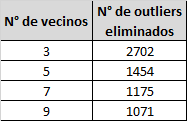

   
Por lo tanto, se selecciona un n-vecinos igual a 3 para la eliminación de outliers.



In [ ]:
# Detección de outlers no supervisado basado en LOF

# Predicción de los datos atípicos
LOF = LocalOutlierFactor(n_neighbors = 3, algorithm = 'auto', metric = 'euclidean') 
Filtrado = LOF.fit_predict(variables_num) 
NOF = LOF.negative_outlier_factor_ 
                                  
# Radio de detección de datos atípicos
radio_outiler = (NOF.max() - NOF)/(NOF.max() - NOF.min()) 
ground_truth = np.ones(len(variables_num), dtype = int) 

# Número de datos atípicos
n_errors = (Filtrado != ground_truth).sum()
print("Número de muestras o filas con datos atípicos: ", n_errors)

Número de muestras o filas con datos atípicos:  2702


In [ ]:
# Eliminación de outliers
eliminacion_outliers= np.where(Filtrado == ground_truth) # Se identifican en que muestras o filas de nuestra base de datos hay presencia de datos atípicos
eliminacion_outliers= np.asarray(eliminacion_outliers)
eliminacion_outliers= np.hstack(eliminacion_outliers)
atbp= application_train_bureau_previous.loc[eliminacion_outliers, :].reset_index(drop=True)

print("Número de muestras sin outilers:",atbp.shape[0])
atbp.head(2)

Número de muestras sin outilers: 244706


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT_x,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_x,HOUR_APPR_PROCESS_START_x,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_SUM,EXT_SOURCE_2,EXT_SOURCE_3,CNT_FAM_MEMBERS,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER,NAME_TYPE_SUITE,ORGANIZATION_TYPE,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Mortgage,SK_ID_PREV,AMT_CREDIT_y,WEEKDAY_APPR_PROCESS_START_y,HOUR_APPR_PROCESS_START_y,DAYS_DECISION,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Others channels,CHANNEL_TYPE_Stone,PRODUCT_COMBINATION_Card
0,100002,1,Cash loans,N,Y,202500.0,406597.5,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,0,1,0,2,WEDNESDAY,10,0,0,1,0.262949,0.139376,1.0,2.0,2.0,-1134.0,0.0,0.0,1.0,M,Unaccompanied,Business Entity,8,2,-103,780.0,865055.565,245781.0,0.0,-1185,0.0,4.0,0.0,1,179055.0,SATURDAY,9,-606,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,100003,0,Cash loans,N,N,270000.0,1293502.5,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,0,1,0,1,MONDAY,11,0,0,1,0.622246,0.510853,2.0,1.0,0.0,-828.0,0.0,0.0,0.0,F,Family,Education,4,1,-606,1216.0,1017400.500,0.0,0.0,-2131,0.0,2.0,0.0,3,1452573.0,FRIDAY,12,-746,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0


In [ ]:
# Tamaño de los datos originales sin nulos
print(application_train_bureau_previous.shape) 

(247408, 64)


In [ ]:
# Tamaño de los datos sin nulos y sin outliers 
print(atbp.shape) 

(244706, 64)


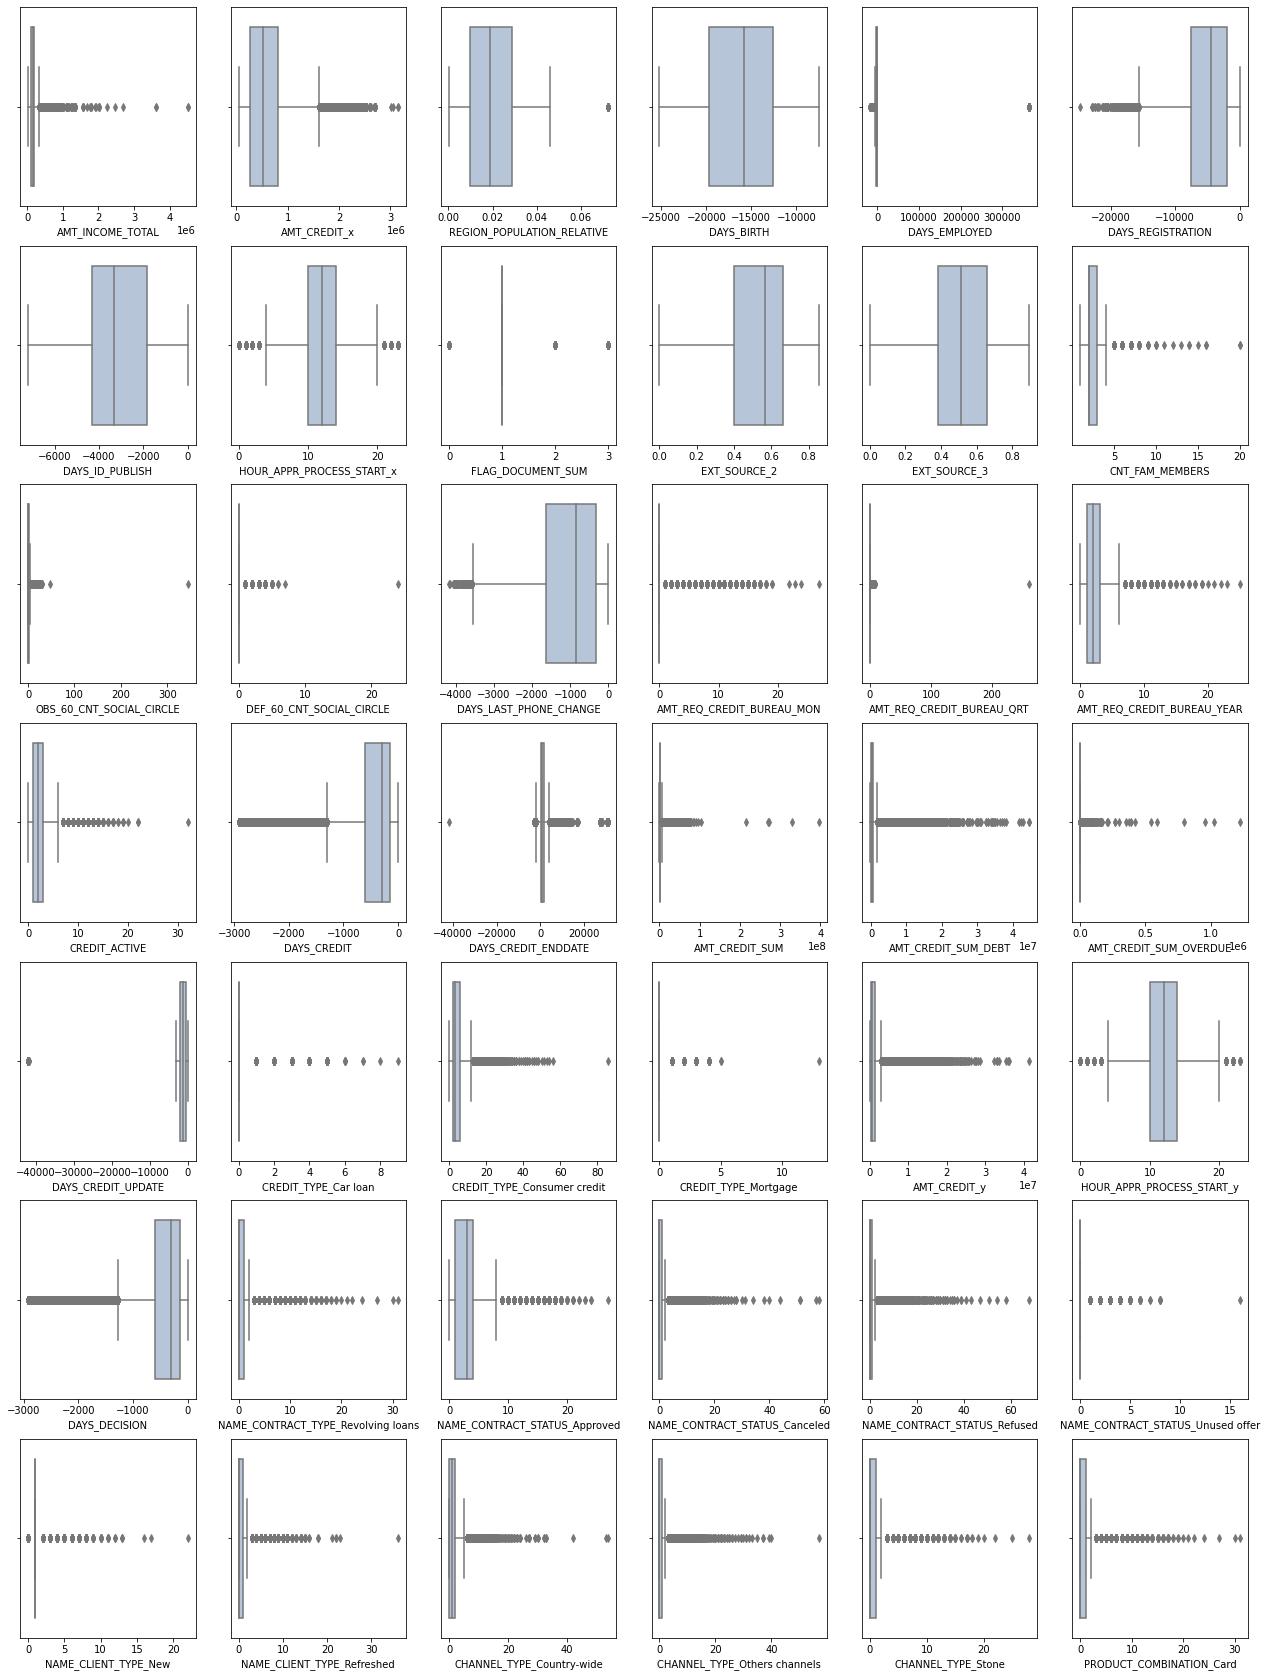

In [ ]:
plt.figure(figsize=(22,30))
for i,c in enumerate(['AMT_INCOME_TOTAL', 'AMT_CREDIT_x','REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED','DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
                      'HOUR_APPR_PROCESS_START_x', 'FLAG_DOCUMENT_SUM', 'EXT_SOURCE_2','EXT_SOURCE_3', 'CNT_FAM_MEMBERS', 'OBS_60_CNT_SOCIAL_CIRCLE',
                      'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE','AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR',
                      'CREDIT_ACTIVE','DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE', 
                      'DAYS_CREDIT_UPDATE','CREDIT_TYPE_Car loan', 'CREDIT_TYPE_Consumer credit','CREDIT_TYPE_Mortgage', 'AMT_CREDIT_y',
                      'HOUR_APPR_PROCESS_START_y', 'DAYS_DECISION','NAME_CONTRACT_TYPE_Revolving loans', 'NAME_CONTRACT_STATUS_Approved',
                      'NAME_CONTRACT_STATUS_Canceled', 'NAME_CONTRACT_STATUS_Refused','NAME_CONTRACT_STATUS_Unused offer', 'NAME_CLIENT_TYPE_New',
                      'NAME_CLIENT_TYPE_Refreshed', 'CHANNEL_TYPE_Country-wide','CHANNEL_TYPE_Others channels', 'CHANNEL_TYPE_Stone','PRODUCT_COMBINATION_Card']):    
  plt.subplot(7,6,i+1)
  sns.boxplot(x=atbp[c], color="lightsteelblue")

**Transformación de variables categóricas**

En la transformación de variables categóricas se determinan todas las categorías a transformar de cada variable, donde se encuentra que todas corresponden a variables categóricas de tipo nominal. Por lo tanto, se decide hacer uso de la metodología One Hot Encoder para asignarle un valor binario a cada categoría representada en nuevas columnas.

In [ ]:
df_categorico=atbp.select_dtypes(include='object')
df_categorico.columns

Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START_x', 'CODE_GENDER',
       'NAME_TYPE_SUITE', 'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START_y'],
      dtype='object')

In [ ]:
# Valores únicos de las variables categóricas
print("NAME_CONTRACT_TYPE =", str(atbp["NAME_CONTRACT_TYPE"].unique()))
print("FLAG_OWN_CAR =", str(atbp["FLAG_OWN_CAR"].unique()))
print("FLAG_OWN_REALTY=", str(atbp["FLAG_OWN_REALTY"].unique()))
print("NAME_INCOME_TYPE =", str(atbp["NAME_INCOME_TYPE"].unique()))
print("NAME_EDUCATION_TYPE =", str(atbp["NAME_EDUCATION_TYPE"].unique()))
print("NAME_FAMILY_STATUS =", str(atbp["NAME_FAMILY_STATUS"].unique()))
print("NAME_HOUSING_TYPE =", str(atbp["NAME_HOUSING_TYPE"].unique()))
print("WEEKDAY_APPR_PROCESS_START_x =", str(atbp["WEEKDAY_APPR_PROCESS_START_x"].unique()))
print("CODE_GENDER =", str(atbp["CODE_GENDER"].unique()))
print("NAME_TYPE_SUITE =", str(atbp["NAME_TYPE_SUITE"].unique()))
print("ORGANIZATION_TYPE =", str(atbp["ORGANIZATION_TYPE"].unique()))
print("WEEKDAY_APPR_PROCESS_START_y =", str(atbp["WEEKDAY_APPR_PROCESS_START_y"].unique()))

NAME_CONTRACT_TYPE = ['Cash loans' 'Revolving loans']
FLAG_OWN_CAR = ['N' 'Y']
FLAG_OWN_REALTY= ['Y' 'N']
NAME_INCOME_TYPE = ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student']
NAME_EDUCATION_TYPE = ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS = ['Single / not married' 'Married' 'Widow' 'Civil marriage' 'Separated']
NAME_HOUSING_TYPE = ['House / apartment' 'Rented apartment' 'Municipal apartment'
 'With parents' 'Office apartment' 'Co-op apartment']
WEEKDAY_APPR_PROCESS_START_x = ['WEDNESDAY' 'MONDAY' 'THURSDAY' 'SUNDAY' 'SATURDAY' 'FRIDAY' 'TUESDAY']
CODE_GENDER = ['M' 'F']
NAME_TYPE_SUITE = ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' 'Other_B'
 'Group of people']
ORGANIZATION_TYPE = ['Business Entity' 'Education' 'Government' 'Other' 'Medicine'
 'Self-employed' 'Trade' 'Industry' 'Transport']
WEEKDAY_APPR_PROCESS_START_y = ['SATURDAY' 'FRIDAY' 'S

In [ ]:
Datos_categoricos=atbp[["NAME_CONTRACT_TYPE","CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY","NAME_TYPE_SUITE","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE","WEEKDAY_APPR_PROCESS_START_x","ORGANIZATION_TYPE", "WEEKDAY_APPR_PROCESS_START_y"]]

A continuación se aplica la metodología One Hot Encoder a las variables categóricas del problema.

In [ ]:
# Aplicación de One Hot Encoder
ENC = OneHotEncoder(handle_unknown='ignore')
ENC.fit(Datos_categoricos)
ENC.categories_

[array(['Cash loans', 'Revolving loans'], dtype=object),
 array(['F', 'M'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['Children', 'Family', 'Group of people', 'Other_A', 'Other_B',
        'Spouse, partner', 'Unaccompanied'], dtype=object),
 array(['Commercial associate', 'Pensioner', 'State servant', 'Student',
        'Unemployed', 'Working'], dtype=object),
 array(['Academic degree', 'Higher education', 'Incomplete higher',
        'Lower secondary', 'Secondary / secondary special'], dtype=object),
 array(['Civil marriage', 'Married', 'Separated', 'Single / not married',
        'Widow'], dtype=object),
 array(['Co-op apartment', 'House / apartment', 'Municipal apartment',
        'Office apartment', 'Rented apartment', 'With parents'],
       dtype=object),
 array(['FRIDAY', 'MONDAY', 'SATURDAY', 'SUNDAY', 'THURSDAY', 'TUESDAY',
        'WEDNESDAY'], dtype=object),
 array(['Business Entity', 'Education', 'Government', 'Industry',
   

In [ ]:
# Características codificadas
Data_One = ENC.transform(Datos_categoricos).toarray() # Codificación One-Hot Encoding
print('Número de características codificadas: ', Data_One.shape[1])

Número de características codificadas:  60


In [ ]:
Data_Cat = ENC.get_feature_names(["NAME_CONTRACT_TYPE","CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY","NAME_TYPE_SUITE","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE","WEEKDAY_APPR_PROCESS_START","ORGANIZATION_TYPE", "WEEKDAY_APPR_PROCESS_START_y"])
Data_One = pd.DataFrame(Data_One, columns = Data_Cat)
Data_One.head(2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity,ORGANIZATION_TYPE_Education,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,WEEKDAY_APPR_PROCESS_START_y_FRIDAY,WEEKDAY_APPR_PROCESS_START_y_MONDAY,WEEKDAY_APPR_PROCESS_START_y_SATURDAY,WEEKDAY_APPR_PROCESS_START_y_SUNDAY,WEEKDAY_APPR_PROCESS_START_y_THURSDAY,WEEKDAY_APPR_PROCESS_START_y_TUESDAY,WEEKDAY_APPR_PROCESS_START_y_WEDNESDAY
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
atbp.drop(["NAME_CONTRACT_TYPE","CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY","NAME_TYPE_SUITE","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE","WEEKDAY_APPR_PROCESS_START_x","ORGANIZATION_TYPE", "WEEKDAY_APPR_PROCESS_START_y"],axis="columns",inplace=True)

In [ ]:
atbp_transf=pd.concat([atbp,Data_One], axis=1)
pd.set_option('display.max_columns', None)
atbp_transf.head(2)

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_x,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_SUM,EXT_SOURCE_2,EXT_SOURCE_3,CNT_FAM_MEMBERS,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Mortgage,SK_ID_PREV,AMT_CREDIT_y,HOUR_APPR_PROCESS_START_y,DAYS_DECISION,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Others channels,CHANNEL_TYPE_Stone,PRODUCT_COMBINATION_Card,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity,ORGANIZATION_TYPE_Education,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,WEEKDAY_APPR_PROCESS_START_y_FRIDAY,WEEKDAY_APPR_PROCESS_START_y_MONDAY,WEEKDAY_APPR_PROCESS_START_y_SATURDAY,WEEKDAY_APPR_PROCESS_START_y_SUNDAY,WEEKDAY_APPR_PROCESS_START_y_THURSDAY,WEEKDAY_APPR_PROCESS_START_y_TUESDAY,WEEKDAY_APPR_PROCESS_START_y_WEDNESDAY
0,100002,1,202500.0,406597.5,0.018801,-9461,-637,-3648.0,-2120,0,1,0,2,10,0,0,1,0.262949,0.139376,1.0,2.0,2.0,-1134.0,0.0,0.0,1.0,8,2,-103,780.0,865055.565,245781.0,0.0,-1185,0.0,4.0,0.0,1,179055.0,9,-606,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,100003,0,270000.0,1293502.5,0.003541,-16765,-1188,-1186.0,-291,0,1,0,1,11,0,0,1,0.622246,0.510853,2.0,1.0,0.0,-828.0,0.0,0.0,0.0,4,1,-606,1216.0,1017400.500,0.0,0.0,-2131,0.0,2.0,0.0,3,1452573.0,12,-746,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Tamaño de los datos sin nulos, sin outliers y con transformación de variables categóricas
atbp_transf.shape

(244706, 112)

Se visualiza el tipo de dato para cada variable después de realizar la transformación de las variables categóricas.

In [ ]:
atbp_transf.dtypes

SK_ID_CURR                                             int64
TARGET                                                 int64
AMT_INCOME_TOTAL                                     float64
AMT_CREDIT_x                                         float64
REGION_POPULATION_RELATIVE                           float64
DAYS_BIRTH                                             int64
DAYS_EMPLOYED                                          int64
DAYS_REGISTRATION                                    float64
DAYS_ID_PUBLISH                                        int64
FLAG_WORK_PHONE                                        int64
FLAG_PHONE                                             int64
FLAG_EMAIL                                             int64
REGION_RATING_CLIENT_W_CITY                            int64
HOUR_APPR_PROCESS_START_x                              int64
REG_CITY_NOT_LIVE_CITY                                 int64
REG_CITY_NOT_WORK_CITY                                 int64
FLAG_DOCUMENT_SUM       

**Correlación con variables transformadas**

Se determina la matriz de correlación entre las variables para identificar posibles correlaciones altas con la variable TARGET. 
Después de realizar una búsqueda, se identifica que ninguna variable presenta una correlación mayor al 20% con el TARGET. Sin embargo, se incluirán todas las variables en la generación del modelo de clasificación.

In [ ]:
Matriz_Correlacion_application_train_2= atbp_transf.corr(method='pearson')
pd.set_option("max_rows", None)
pd.set_option("max_colwidth", None)
Matriz_Correlacion_application_train_2["TARGET"]

SK_ID_CURR                                          -0.003223
TARGET                                               1.000000
AMT_INCOME_TOTAL                                    -0.016378
AMT_CREDIT_x                                        -0.026852
REGION_POPULATION_RELATIVE                          -0.032648
DAYS_BIRTH                                           0.079354
DAYS_EMPLOYED                                       -0.045390
DAYS_REGISTRATION                                    0.041786
DAYS_ID_PUBLISH                                      0.049817
FLAG_WORK_PHONE                                      0.026293
FLAG_PHONE                                          -0.023870
FLAG_EMAIL                                          -0.000313
REGION_RATING_CLIENT_W_CITY                          0.056089
HOUR_APPR_PROCESS_START_x                           -0.020549
REG_CITY_NOT_LIVE_CITY                               0.042808
REG_CITY_NOT_WORK_CITY                               0.048956
FLAG_DOC

**Balanceo de la variable objetivo**

Teniendo en cuenta que la variable objetivo TARGET presenta un desbalance muy significativo en sus clases, donde hay 225586 registros de la clase 0 y solamente 19120 de la clase 1; se implementan dos métodos de balanceo, con el fin de comparar como los resultados de los modelos se ven afectados por ambos métodos de balanceo.


**Oversampling:** se emplea la técnica SMOTE para crear valores sintéticos en la clase 1, la cual representa la menor proporción de registros de la variable TARGET.

**Undersampling:** se escoge aleatoriamente una muestra para la clase 0 con el mismo tamaño de la cantidad minoritaria de las clases.

# MODELOS

## MODELOS CON OVERSAMPLING

**Oversampling - SMOTE**

Para el balanceo de la variable objetivo se usará la técnica SMOTE, la cual equilibrará la distribución de clases aumentando aleatoriamente los ejemplos de clases minoritarias al replicarlos.

In [ ]:
# Variable objetivo inicial con un notable desbalanceo de las clases
pd.value_counts(atbp_transf["TARGET"]).plot(kind="bar")
plt.title("TARGET")

In [ ]:
Clase_0=atbp_transf[atbp_transf["TARGET"]==0]
Clase_1=atbp_transf[atbp_transf["TARGET"]==1]

print("Dimensión de la Clase 0: ",Clase_0.shape)
print("Dimensión de la Clase 1: ",Clase_1.shape)

Dimensión de la Clase 0:  (225586, 112)
Dimensión de la Clase 1:  (19120, 112)


In [ ]:
# Aplicación de la técnica SMOTE para el balanceo de la variable objetivo
x=atbp_transf.drop("TARGET",axis="columns")
x=np.array(x)
y=atbp_transf["TARGET"]
smote = SMOTE(random_state=42)
x_bal,y_bal=smote.fit_resample(x,y.ravel())

Text(0.5, 1.0, 'TARGET Balanceado')

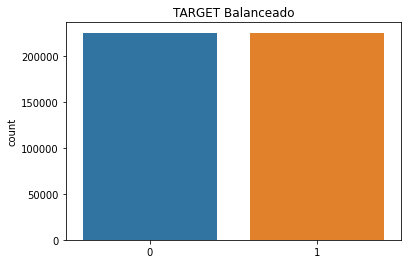

In [ ]:
# Variable objetivo final después de la aplicación de la técnica SMOTE
sns.countplot(x=y_bal);
plt.title("TARGET Balanceado")

In [ ]:
# Nuevas dimensiones generadas
print("Dimensión de la Clase 0: ", len(y_bal[y_bal==0]))
print("Dimensión de la Clase 1: ", len(y_bal[y_bal==1]))
print("Dimensión del dataset: ", len(y_bal))

Dimensión de la Clase 0:  225586
Dimensión de la Clase 1:  225586
Dimensión del dataset:  451172


**Modelos de predicción supervisado con Oversampling**

Para la partición de los datos, se utiliza la función “train_test_split”, la cual divide el dataset en dos bloques, en este caso, uno de train con el 70% de los datos y otro de test con el 30% restante.

In [ ]:
#Split de los datos de train y test
X_train, X_test, y_train, y_test = train_test_split(x_bal,y_bal, test_size=0.3, random_state=1)

In [ ]:
#Estandarización de variables
scaler = StandardScaler().fit(X_train)
X_train_n=scaler.transform(X_train)
X_test_n=scaler.transform(X_test)

**Modelo de Regresión Logística**

Para el modelo de Regresión Logística se emplea un Grid Search con el objetivo de encontrar los mejores hiperparámetros que se ajustan al modelo.

**Solver:** se entrena el modelo con *newton-cg*, *sag* y *saga*, considerando que éstos son más apropiados para el tipo de problema abordado, debido que *liblinear* se utiliza para problemas multiclase y *lbfgs* se emplea principalmente para pequeños conjuntos de datos.

**Penalty:** se entrena el modelo con *none* y *l2*, los cuales aplican para los tipos de solver seleccionados.

**C:** se entrena el modelo con valores de 1.0, 0.1, 0.01 y 10.

In [ ]:
# Definición de parámetros

C=[1.0,0.1,0.01,10]
penalty=["none", "l2"]

parameters_1= {"C":C,"penalty":penalty}

*SOLVER newton-cg*

In [ ]:
RL = LogisticRegression(solver="newton-cg",random_state=1)
RLG = GridSearchCV(estimator=RL, param_grid = parameters_1, scoring='balanced_accuracy',return_train_score=True)
RLG.fit(X_train_n, y_train)

print(RLG.best_params_)
print("balanced_accuracy "+str(RLG.best_score_))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

{'C': 1.0, 'penalty': 'l2'}
balanced_accuracy 0.7037893195282084


In [ ]:
# Resultados
resultados_RLG = pd.DataFrame(RLG.cv_results_)
resultados_RLG.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False)

,param_C,param_penalty,mean_test_score,std_test_score,mean_train_score,std_train_score
1,1.0,l2,0.703789,0.001573,0.704008,0.000396
7,10,l2,0.703697,0.001616,0.703937,0.000346
0,1.0,none,0.703688,0.001630,0.703924,0.000353
2,0.1,none,0.703688,0.001630,0.703924,0.000353
4,0.01,none,0.703688,0.001630,0.703924,0.000353
6,10,none,0.703688,0.001630,0.703924,0.000353
3,0.1,l2,0.703663,0.001373,0.703804,0.000380
5,0.01,l2,0.703197,0.001277,0.703338,0.000321


*SOLVER sag*

In [ ]:
RL = LogisticRegression(solver="sag",random_state=1)
RLG = GridSearchCV(estimator=RL, param_grid = parameters_1, scoring='balanced_accuracy',return_train_score=True)
RLG.fit(X_train_n, y_train)

print(RLG.best_params_)
print("balanced_accuracy "+str(RLG.best_score_))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

{'C': 0.01, 'penalty': 'l2'}
balanced_accuracy 0.703175235317791


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
# Resultados
resultados_RLG = pd.DataFrame(RLG.cv_results_)
resultados_RLG.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False)

,param_C,param_penalty,mean_test_score,std_test_score,mean_train_score,std_train_score
5,0.01,l2,0.703175,0.001401,0.703246,0.000369
3,0.1,l2,0.703166,0.001351,0.703258,0.000363
1,1.0,l2,0.703166,0.001361,0.703258,0.000352
0,1.0,none,0.703163,0.001360,0.703256,0.000355
2,0.1,none,0.703163,0.001360,0.703256,0.000355
4,0.01,none,0.703163,0.001360,0.703256,0.000355
6,10,none,0.703163,0.001360,0.703256,0.000355
7,10,l2,0.703163,0.001360,0.703257,0.000354


*SOLVER saga*

In [ ]:
RL = LogisticRegression(solver="saga",random_state=1)
RLG = GridSearchCV(estimator=RL, param_grid = parameters_1, scoring='balanced_accuracy',return_train_score=True)
RLG.fit(X_train_n, y_train)

print(RLG.best_params_)
print("balanced_accuracy "+str(RLG.best_score_))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

{'C': 1.0, 'penalty': 'none'}
balanced_accuracy 0.7031530572577662


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
# Resultados
resultados_RLG = pd.DataFrame(RLG.cv_results_)
resultados_RLG.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False)

,param_C,param_penalty,mean_test_score,std_test_score,mean_train_score,std_train_score
0,1.0,none,0.703153,0.001337,0.703265,0.000353
1,1.0,l2,0.703153,0.001337,0.703267,0.000355
2,0.1,none,0.703153,0.001337,0.703265,0.000353
4,0.01,none,0.703153,0.001337,0.703265,0.000353
6,10,none,0.703153,0.001337,0.703265,0.000353
7,10,l2,0.703153,0.001337,0.703265,0.000353
3,0.1,l2,0.703153,0.001340,0.703265,0.000359
5,0.01,l2,0.703115,0.001394,0.703246,0.000369


Mejor modelo de Regresión Logística

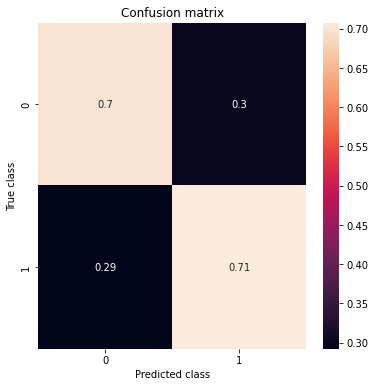

In [ ]:
model_1 = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
model_1.fit(X_train_n, y_train)
 
def resultados(y_test, pred_y1):
    conf_matrix = confusion_matrix(y_test, pred_y1,normalize="true")
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True);
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
 
pred_y = model_1.predict(X_test_n)
resultados(y_test, pred_y)

La matriz de confusión evidencia las probabilidades de las predicciones correctas y los errores de clasificación del modelo de Regresión Logística.

Verdaderos Positivos (TP): 0.70

Verdaderos Negativos (TN): 0.71

Falsos Positivos (FP): 0.29

Falsos Negativos (FN): 0.30



**Modelo de Random Forest**

Para el modelo de Random Forest se emplea un Grid Search con el objetivo de encontrar los mejores hiperparámetros que se ajustan al modelo.

**n_estimators:** se entrena el modelo con valores de 10, 20, 30, 40, 50, 60 y 100.

**max_depth:** se entrena el modelo con valores de 4, 6, 8, 10, 12, 14.

In [ ]:
# Definición de parámetros
n_estimators=[10,20,30,40,50,60,100]
max_depth=[4,6,8,10,12,14]

parameters_2 = {'n_estimators':n_estimators,'max_depth':max_depth}


In [ ]:
RF = RandomForestClassifier(random_state=1)
RFG= GridSearchCV(estimator=RF, param_grid = parameters_2, scoring='balanced_accuracy',return_train_score=True)
RFG.fit(X_train_n, y_train)

print(RFG.best_params_)
print("balanced_accuracy "+str(RFG.best_score_))

{'max_depth': 14, 'n_estimators': 100}
balanced_accuracy 0.9560187933808473


In [ ]:
# Resultados
resultados_RFG = pd.DataFrame(RFG.cv_results_)
resultados_RFG.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False)

,param_max_depth,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
41,14,100,0.956019,0.000607,0.957104,0.000181
40,14,60,0.955864,0.000559,0.957116,0.000184
39,14,50,0.955724,0.000520,0.957106,0.000217
38,14,40,0.955598,0.000478,0.957144,0.000244
37,14,30,0.955367,0.000528,0.957086,0.000277
36,14,20,0.954911,0.000508,0.957012,0.000194
34,12,100,0.954604,0.000671,0.955500,0.000183
33,12,60,0.954265,0.000599,0.955280,0.000252
32,12,50,0.954160,0.000657,0.955196,0.000248
31,12,40,0.953926,0.000508,0.955061,0.000268


Mejor modelo de Random Forest

In [ ]:
model_2 = RandomForestClassifier(random_state=1, max_depth=14, n_estimators=100)
model_2.fit(X_train_n, y_train)

RandomForestClassifier(max_depth=14, random_state=1)

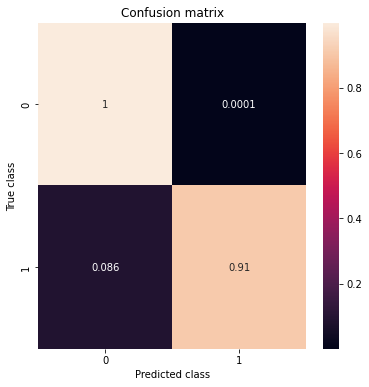

In [ ]:
def resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y,normalize="true")
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True);
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
 
pred_y = model_2.predict(X_test_n)
resultados(y_test, pred_y)

La matriz de confusión evidencia las probabilidades de las predicciones correctas y los errores de clasificación del modelo de Random Forest.

Verdaderos Positivos (TP): 1

Verdaderos Negativos (TN): 0.91

Falsos Positivos (FP): 0.086

Falsos Negativos (FN): 0.0001

**Modelo de Gradient Boosting**



Para el modelo de Gradient Boosting se emplea un Grid Search con el objetivo de encontrar los mejores hiperparámetros que se ajustan al modelo.

**n_estimators:** se entrena el modelo con valores de 20, 40 y 60.

**max_depth:** se entrena el modelo con valores de 6 y 12.

In [ ]:
# Definición de parámetros
n_estimators=[20,40,60]
max_depth=[6]

parameters_3 = {'n_estimators':n_estimators,'max_depth':max_depth}

In [ ]:
GBC = GradientBoostingClassifier(random_state=1)
GBCG = GridSearchCV(estimator=GBC,param_grid =parameters_3,scoring='balanced_accuracy',return_train_score=True)
GBCG = GBCG.fit(X_train_n,y_train)

print(GBCG.best_params_)
print("balanced_accuracy "+str(GBCG.best_score_))

{'max_depth': 6, 'n_estimators': 60}
balanced_accuracy 0.9570000133317272


In [ ]:
# Resultados
resultados_GBCG = pd.DataFrame(GBCG.cv_results_)
resultados_GBCG.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False)

,param_max_depth,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
2,6,60,0.957000,0.000668,0.957551,0.000112
1,6,40,0.956117,0.000729,0.956327,0.000147
0,6,20,0.951369,0.000637,0.951548,0.000463


In [ ]:
n_estimators=[20,40,60]
max_depth=[12]

parameters_3 = {'n_estimators':n_estimators,'max_depth':max_depth}

In [ ]:
GBC = GradientBoostingClassifier(random_state=1)
GBCG = GridSearchCV(estimator=GBC,param_grid =parameters_3,scoring='balanced_accuracy',return_train_score=True)
GBCG = GBCG.fit(X_train_n,y_train)

print(GBCG.best_params_)
print("balanced_accuracy "+str(GBCG.best_score_))

{'max_depth': 12, 'n_estimators': 60}
balanced_accuracy 0.9570247817686178


In [ ]:
# Resultados
resultados_GBCG = pd.DataFrame(GBCG.cv_results_)
resultados_GBCG.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False)

,param_max_depth,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
2,12,60,0.957025,0.000720,0.969588,0.000126
1,12,40,0.957012,0.000645,0.964555,0.000124
0,12,20,0.955604,0.000800,0.959799,0.000139


Mejor modelo de Gradiente Boosting

In [ ]:
model_3 = GradientBoostingClassifier(random_state=1, max_depth=12, n_estimators=60)
model_3.fit(X_train_n, y_train)

GradientBoostingClassifier(max_depth=12, n_estimators=60, random_state=1)

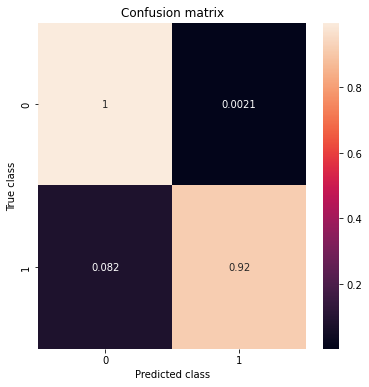

In [ ]:
def resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y,normalize="true")
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True);
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
 
pred_y = model_3.predict(X_test_n)
resultados(y_test, pred_y)

La matriz de confusión evidencia las probabilidades de las predicciones correctas y los errores de clasificación del modelo de Gradiente Boosting.

Verdaderos Positivos (TP): 1

Verdaderos Negativos (TN): 0.92

Falsos Positivos (FP): 0.082

Falsos Negativos (FN): 0.0021

### MÉTRICAS DE MODELOS CON OVERSAMPLING

In [ ]:
labels = ['Regresión Logística', 'Random Forest', 'Gradiente Boosting']
measures = ['accuracy (acc)','precision (ppv)','recall','f1','matthews (mcc)','balanced accuracy (bacc)']
Performance = []
Performance.append([accuracy_score(y_test,model_1.predict(X_test_n)), accuracy_score(y_test,model_2.predict(X_test_n)), accuracy_score(y_test,model_3.predict(X_test_n))])
Performance.append([precision_score(y_test,model_1.predict(X_test_n)), precision_score(y_test,model_2.predict(X_test_n)), precision_score(y_test,model_3.predict(X_test_n))])
Performance.append([recall_score(y_test,model_1.predict(X_test_n)), recall_score(y_test,model_2.predict(X_test_n)), recall_score(y_test,model_3.predict(X_test_n))])
Performance.append([f1_score(y_test,model_1.predict(X_test_n)), f1_score(y_test,model_2.predict(X_test_n)), f1_score(y_test,model_3.predict(X_test_n))])
Performance.append([matthews_corrcoef(y_test,model_1.predict(X_test_n)), matthews_corrcoef(y_test,model_2.predict(X_test_n)), matthews_corrcoef(y_test,model_3.predict(X_test_n))])
Performance.append([balanced_accuracy_score(y_test,model_1.predict(X_test_n)), balanced_accuracy_score(y_test,model_2.predict(X_test_n)), balanced_accuracy_score(y_test,model_3.predict(X_test_n))])

comparativo = pd.DataFrame(Performance,index=measures,columns=labels)
print(comparativo)

                          Regresión Logística  Random Forest  \
accuracy (acc)                       0.703100       0.956898   
precision (ppv)                      0.700922       0.999887   
recall                               0.707845       0.913843   
f1                                   0.704367       0.954930   
matthews (mcc)                       0.406223       0.917189   
balanced accuracy (bacc)             0.703103       0.956870   

                          Gradiente Boosting  
accuracy (acc)                      0.958168  
precision (ppv)                     0.997719  
recall                              0.918382  
f1                                  0.956408  
matthews (mcc)                      0.919240  
balanced accuracy (bacc)            0.958142  


Curva ROC de modelos

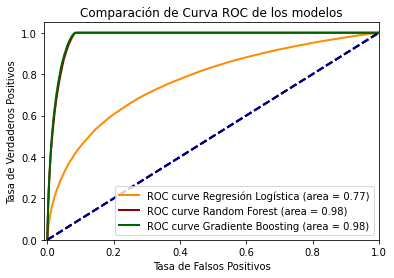

In [ ]:
fpr = list(np.zeros(len(labels)))
tpr = list(np.zeros(len(labels)))

color = ['darkorange','darkred','darkgreen']

y_pred1 = model_1.predict_proba(X_test_n)
y_pred2 = model_2.predict_proba(X_test_n)
y_pred3 = model_3.predict_proba(X_test_n)

y_pred = [y_pred1,y_pred2,y_pred3]

for i in range(len(labels)):

  score = y_pred[i][:,0]-y_pred[i][:,1]
  tpr[i],fpr[i],_ = roc_curve(y_test, score)
  roc_auc = auc(fpr[i], tpr[i])
  plt.plot(fpr[i], tpr[i], color= color[i], lw=2, label= 'ROC curve %s (area = %0.2f)' %(labels[i],roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([-0.01, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Tasa de Falsos Positivos')
  plt.ylabel('Tasa de Verdaderos Positivos')
  plt.title('Comparación de Curva ROC de los modelos')
  plt.legend(loc="lower right")

plt.show()

La curva ROC evidencia que los modelos Random Forest y Gradiente Boosting presentan un desempeño esperado del sistema de clasificación del 98%, mientras que el modelo de Regresión Logística evidencia un desempeño del 77%.

Por tanto, considerando los resultados de las métricas de evaluación y la Curva ROC, se determina que el modelo con resultados más acertados es el Gradiente Boosting.

Con los resultados obtenidos por los últimos dos modelos, se puede intuir que los modelos se han visto afectados por la metodología de balanceo utilizada previamente (SMOTE), posiblemente por la generación de gran cantidad de datos sintéticos de la clase 1.

### MODELO ÓPTIMO CON OVERSAMPLING

Se emplea la metodología Stratified K Fold para entrenar el modelo Gradient Boosting seleccionado como el modelo de mejor desempeño entrenado con los datos resultantes del balanceo oversampling, implementando ahora la validación cruzada.

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
model = GradientBoostingClassifier(random_state=1, max_depth=12, n_estimators=60)

In [ ]:
model = GradientBoostingClassifier(random_state=1, max_depth=12, n_estimators=60)
clf=model.fit(X_train_n, y_train)

In [ ]:
scores=cross_val_score(clf,x_bal,y_bal,cv=skf,scoring="balanced_accuracy")
scores

array([0.67180962, 0.67573222, 0.67573222, 0.68200837, 0.67547071,
       0.67180962, 0.67311715, 0.68436192, 0.66370293, 0.67782427])

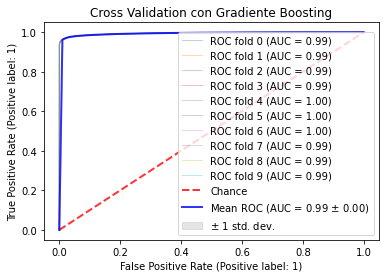

In [ ]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(skf.split(x_bal, y_bal)):
    model.fit(x_bal[train], y_bal[train])
    viz = RocCurveDisplay.from_estimator(
        model,
        x_bal[train],
        y_bal[train],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Cross Validation con Gradiente Boosting",
)
ax.legend(loc="lower right")
plt.show()

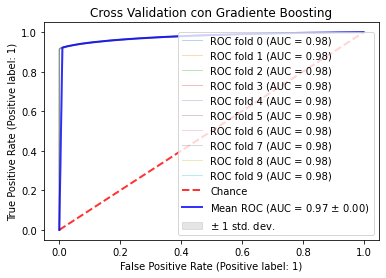

In [ ]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(skf.split(x_bal, y_bal)):
    model.fit(x_bal[train], y_bal[train])
    viz = RocCurveDisplay.from_estimator(
        model,
        x_bal[test],
        y_bal[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Cross Validation con Gradiente Boosting",
)
ax.legend(loc="lower right")
plt.show()

## MODELOS CON UNDERSAMPLING

**Undersampling**

Para el segundo método de balanceo se utiliza *sample* con el fin de determinar aleatoriamente una muestra para la clase 0 con el mismo tamaño de la cantidad minoritaria de las clases.

Text(0.5, 1.0, 'TARGET')

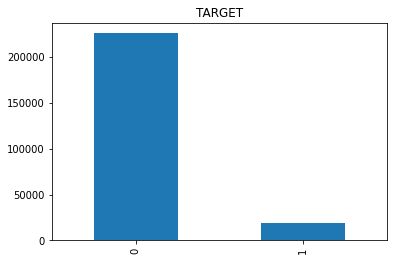

In [ ]:
# Variable objetivo inicial con un notable desbalanceo de las clases
pd.value_counts(atbp_transf["TARGET"]).plot(kind="bar")
plt.title("TARGET")

In [ ]:
Clase_0=atbp_transf[atbp_transf["TARGET"]==0]
Clase_1=atbp_transf[atbp_transf["TARGET"]==1]

print("Dimensión de la Clase 0: ",Clase_0.shape)
print("Dimensión de la Clase 1: ",Clase_1.shape)

Dimensión de la Clase 0:  (225586, 112)
Dimensión de la Clase 1:  (19120, 112)


In [ ]:
# Aplicación de balanceo para la variable objetivo
count_Clase_0,count_Clase_1=atbp_transf.TARGET.value_counts()
Clase_0_bal=Clase_0.sample(count_Clase_1)
reduccion=pd.concat([Clase_0_bal,Clase_1])

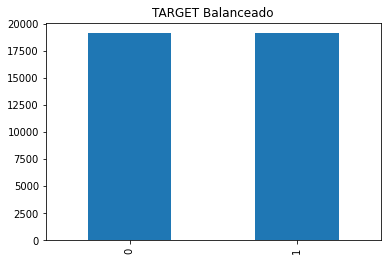

In [ ]:
reduccion.TARGET.value_counts().plot(kind='bar', title="TARGET Balanceado")

In [ ]:
# Nuevas dimensiones generadas
print("Dimensión de la Clase 0: ",Clase_0_bal.shape)
print("Dimensión de la Clase 1: ",Clase_1.shape)
print("Dimensión del dataset: ",reduccion.shape)

Dimensión de la Clase 0:  (19120, 112)
Dimensión de la Clase 1:  (19120, 112)
Dimensión del dataset:  (38240, 112)


In [ ]:
x_bal=reduccion.drop("TARGET",axis="columns")
y_bal=reduccion["TARGET"]

**Modelos de predicción supervisado con Undersampling**

Para la partición de los datos, se utiliza la función “train_test_split”, la cual divide el dataset en dos bloques, en este caso, uno de train con el 70% de los datos y otro de test con el 30% restante.

In [ ]:
# Split de los datos de train y test
X_train, X_test, y_train, y_test = train_test_split(x_bal,y_bal, test_size=0.3, random_state=1)

In [ ]:
# Estandarización de variables
scaler = StandardScaler().fit(X_train)
X_train_n=scaler.transform(X_train)
X_test_n=scaler.transform(X_test)

**Modelo de Regresión Logística**

Para el modelo de Regresión Logística se emplea un Grid Search con el objetivo de encontrar los mejores hiperparámetros que se ajustan al modelo.

**Solver:** se entrena el modelo con *newton-cg*, *sag* y *saga*, considerando que éstos son más apropiados para el tipo de problema abordado, debido que *liblinear* se utiliza para problemas multiclase y *lbfgs* se emplea principalmente para pequeños conjuntos de datos.

**Penalty:** se entrena el modelo con *none*, *l1* y *l2*, los cuales aplican para los tipos de solver seleccionados.

**C:** se entrena el modelo con valores de 1.0, 0.1, 0.01, 0.001 y 10.

In [ ]:
# Definición de parámetros
C=[1.0,0.1,0.01,0.001,10]
penalty=["none","l1","l2"]
solver=["newton-cg","sag","saga"]

parameters_1= {"C":C,"penalty":penalty,"solver":solver}

In [ ]:
RL = LogisticRegression(random_state=1)
RLG = GridSearchCV(estimator=RL, param_grid = parameters_1, scoring='balanced_accuracy',return_train_score=True)
RLG.fit(X_train_n, y_train)

print(RLG.best_params_)
print("balanced_accuracy "+str(RLG.best_score_))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
balanced_accuracy 0.6841641816076902


In [ ]:
# Resultados
resultados_RLG = pd.DataFrame(RLG.cv_results_)
resultados_RLG.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False)

,param_C,param_penalty,param_solver,mean_test_score,std_test_score,mean_train_score,std_train_score
42,10,l2,newton-cg,0.684164,0.004377,0.687497,0.001088
6,1.0,l2,newton-cg,0.683420,0.005361,0.687327,0.001556
14,0.1,l1,saga,0.683278,0.003521,0.686845,0.001508
0,1.0,none,newton-cg,0.683154,0.004178,0.687003,0.001310
9,0.1,none,newton-cg,0.683154,0.004178,0.687003,0.001310
36,10,none,newton-cg,0.683154,0.004178,0.687003,0.001310
18,0.01,none,newton-cg,0.683154,0.004178,0.687003,0.001310
27,0.001,none,newton-cg,0.683154,0.004178,0.687003,0.001310
20,0.01,none,saga,0.682974,0.004415,0.686366,0.001509
2,1.0,none,saga,0.682974,0.004415,0.686366,0.001509


Mejor modelo de Regresión Logística

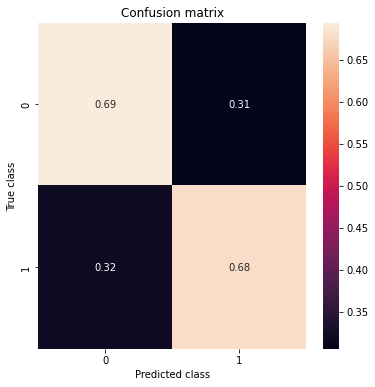

In [ ]:
model_1 = LogisticRegression(C=10,penalty='l2',random_state=1,solver="newton-cg")
model_1.fit(X_train_n, y_train)
 
def resultados(y_test, pred_y1):
    conf_matrix = confusion_matrix(y_test, pred_y1,normalize="true")
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True);
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
 
pred_y = model_1.predict(X_test_n)
resultados(y_test, pred_y)

La matriz de confusión evidencia las probabilidades de las predicciones correctas y los errores de clasificación del modelo de Regresión Logística.

Verdaderos Positivos (TP): 0.69

Verdaderos Negativos (TN): 0.68

Falsos Positivos (FP): 0.32

Falsos Negativos (FN): 0.31

**Modelo de Random Forest**

Para el modelo de Random Forest se emplea un Grid Search con el objetivo de encontrar los mejores hiperparámetros que se ajustan al modelo.

**n_estimators:** se entrena el modelo con valores de 20, 40, 60, 100, 120, 150, 180 y 200.

**max_depth:** se entrena el modelo con valores de 4, 8, 12, 14, 18 y 20.

In [ ]:
# Definición de parámetros
n_estimators=[20,40,60,100,120,150,180,200]
max_depth=[4,8,12,14,18,20]

parameters_2 = {'n_estimators':n_estimators,'max_depth':max_depth}

In [ ]:
RF = RandomForestClassifier(random_state=1)
RFG= GridSearchCV(estimator=RF, param_grid = parameters_2, scoring='balanced_accuracy',return_train_score=True)
RFG.fit(X_train_n, y_train)

print(RFG.best_params_)
print("balanced_accuracy "+str(RFG.best_score_))

{'max_depth': 18, 'n_estimators': 180}
balanced_accuracy 0.6828997520319386


In [ ]:
# Resultados
resultados_RFG = pd.DataFrame(RFG.cv_results_)
resultados_RFG.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False)

,param_max_depth,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
38,18,180,0.682900,0.005855,0.996051,0.000321
23,12,200,0.682840,0.004525,0.875306,0.001900
31,14,200,0.682684,0.003655,0.942223,0.002007
39,18,200,0.682636,0.005979,0.996238,0.000263
22,12,180,0.682015,0.003712,0.874622,0.002081
29,14,150,0.681976,0.004982,0.941905,0.002064
21,12,150,0.681822,0.004104,0.874771,0.001450
37,18,150,0.681663,0.007044,0.995846,0.000379
30,14,180,0.681371,0.003647,0.942081,0.002064
28,14,120,0.681345,0.004921,0.940349,0.001991


Mejor modelo de Random Forest

In [ ]:
model_2 = RandomForestClassifier(random_state=1, max_depth=18, n_estimators=180)
model_2.fit(X_train_n, y_train)

RandomForestClassifier(max_depth=18, n_estimators=180, random_state=1)

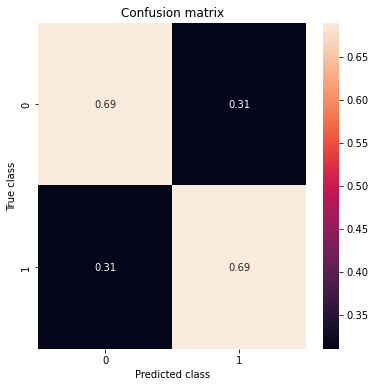

In [ ]:
def resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y,normalize="true")
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True);
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
 
pred_y = model_2.predict(X_test_n) #sale error 111 features en X y RandomForestClassifier solo recibe 4
resultados(y_test, pred_y)

La matriz de confusión evidencia las probabilidades de las predicciones correctas y los errores de clasificación del modelo de Random Forest.

Verdaderos Positivos (TP): 0.69

Verdaderos Negativos (TN): 0.69

Falsos Positivos (FP): 0.31

Falsos Negativos (FN): 0.31

**Modelo de Gradient Boosting**



Para el modelo de Gradient Boosting se emplea un Grid Search con el objetivo de encontrar los mejores hiperparámetros que se ajustan al modelo.

**n_estimators:** se entrena el modelo con valores de 10, 20, 40, 60, 100 y 120.

**max_depth:** se entrena el modelo con valores de 4, 8, 12 y 14.

In [ ]:
# Definición de parámetros
n_estimators=[10,20,40,60,100,120]
max_depth=[4,8,12,14]

parameters_3 = {'n_estimators':n_estimators,'max_depth':max_depth}

In [ ]:
GBC = GradientBoostingClassifier(random_state=1)
GBCG = GridSearchCV(estimator=GBC,param_grid =parameters_3,scoring='balanced_accuracy',return_train_score=True)
GBCG = GBCG.fit(X_train_n,y_train)

print(GBCG.best_params_)
print("balanced_accuracy "+str(GBCG.best_score_))

{'max_depth': 4, 'n_estimators': 120}
balanced_accuracy 0.6867281731970516


In [ ]:
# Resultados
resultados_GBCG = pd.DataFrame(GBCG.cv_results_)
resultados_GBCG.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False)

,param_max_depth,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
5,4,120,0.686728,0.004391,0.732946,0.001491
4,4,100,0.685649,0.004969,0.726899,0.001546
3,4,60,0.681461,0.005659,0.711145,0.001129
9,8,60,0.681161,0.006099,0.879989,0.001812
11,8,120,0.680781,0.004688,0.937077,0.005347
10,8,100,0.680263,0.005414,0.921389,0.002432
2,4,40,0.678520,0.005033,0.700074,0.001956
8,8,40,0.678058,0.005570,0.847153,0.001617
23,14,120,0.673990,0.005845,1.000000,0.000000
7,8,20,0.673836,0.007673,0.798178,0.002405


Mejor modelo de Gradiente Boosting

In [ ]:
model_3 = GradientBoostingClassifier(random_state=1, max_depth=4, n_estimators=120)
model_3.fit(X_train_n, y_train)

GradientBoostingClassifier(max_depth=4, n_estimators=120, random_state=1)

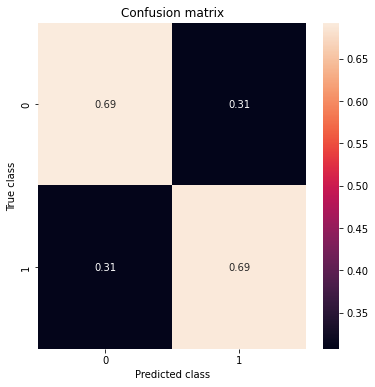

In [ ]:
def resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y,normalize="true")
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True);
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
 
pred_y = model_3.predict(X_test_n)
resultados(y_test, pred_y)

La matriz de confusión evidencia las probabilidades de las predicciones correctas y los errores de clasificación del modelo de Gradiente Boosting.

Verdaderos Positivos (TP): 0.69

Verdaderos Negativos (TN): 0.69

Falsos Positivos (FP): 0.31

Falsos Negativos (FN): 0.31

### MÉTRICAS DE MODELOS CON UNDERSAMPLING

In [ ]:
labels = ['Regresión Logística', 'Random Forest', 'Gradiente Boosting']
measures = ['accuracy (acc)','precision (ppv)','recall','f1','matthews (mcc)','balanced accuracy (bacc)']
Performance = []
Performance.append([accuracy_score(y_test,model_1.predict(X_test_n)), accuracy_score(y_test,model_2.predict(X_test_n)), accuracy_score(y_test,model_3.predict(X_test_n))])
Performance.append([precision_score(y_test,model_1.predict(X_test_n)), precision_score(y_test,model_2.predict(X_test_n)), precision_score(y_test,model_3.predict(X_test_n))])
Performance.append([recall_score(y_test,model_1.predict(X_test_n)), recall_score(y_test,model_2.predict(X_test_n)), recall_score(y_test,model_3.predict(X_test_n))])
Performance.append([f1_score(y_test,model_1.predict(X_test_n)), f1_score(y_test,model_2.predict(X_test_n)), f1_score(y_test,model_3.predict(X_test_n))])
Performance.append([matthews_corrcoef(y_test,model_1.predict(X_test_n)), matthews_corrcoef(y_test,model_2.predict(X_test_n)), matthews_corrcoef(y_test,model_3.predict(X_test_n))])
Performance.append([balanced_accuracy_score(y_test,model_1.predict(X_test_n)), balanced_accuracy_score(y_test,model_2.predict(X_test_n)), balanced_accuracy_score(y_test,model_3.predict(X_test_n))])

comparativo = pd.DataFrame(Performance,index=measures,columns=labels)
print(comparativo)

                          Regresión Logística  Random Forest  \
accuracy (acc)                       0.686977       0.688982   
precision (ppv)                      0.684781       0.684303   
recall                               0.679831       0.688646   
f1                                   0.682297       0.686467   
matthews (mcc)                       0.373836       0.377937   
balanced accuracy (bacc)             0.686898       0.688978   

                          Gradiente Boosting  
accuracy (acc)                      0.691510  
precision (ppv)                     0.687072  
recall                              0.690585  
f1                                  0.688824  
matthews (mcc)                      0.382982  
balanced accuracy (bacc)            0.691500  


Curva ROC de modelos

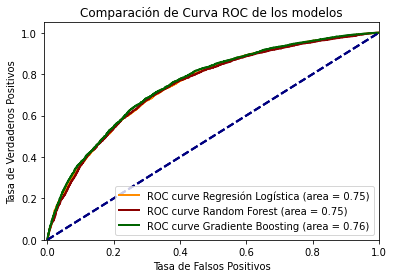

In [ ]:
fpr = list(np.zeros(len(labels)))
tpr = list(np.zeros(len(labels)))

color = ['darkorange','darkred','darkgreen']

y_pred1 = model_1.predict_proba(X_test_n)
y_pred2 = model_2.predict_proba(X_test_n)
y_pred3 = model_3.predict_proba(X_test_n)

y_pred = [y_pred1,y_pred2,y_pred3]

for i in range(len(labels)):

  score = y_pred[i][:,0]-y_pred[i][:,1]
  tpr[i],fpr[i],_ = roc_curve(y_test, score)
  roc_auc = auc(fpr[i], tpr[i])
  plt.plot(fpr[i], tpr[i], color= color[i], lw=2, label= 'ROC curve %s (area = %0.2f)' %(labels[i],roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([-0.01, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Tasa de Falsos Positivos')
  plt.ylabel('Tasa de Verdaderos Positivos')
  plt.title('Comparación de Curva ROC de los modelos')
  plt.legend(loc="lower right")

plt.show()

La curva ROC evidencia que los modelos Regresión Logística y Random Forest presentan un desempeño esperado del sistema de clasificación del 75%, mientras que el modelo de Gradiente Boosting evidencia un desempeño del 76%.

Por tanto, considerando los resultados de las métricas de evaluación y la Curva ROC, se determina que el modelo con resultados más acertados es el Gradiente Boosting.


### MODELO ÓPTIMO CON UNDERSAMPLING

Se emplea la metodología Stratified K Fold para entrenar el modelo Gradient Boosting seleccionado como el modelo de mejor desempeño entrenado con los datos resultantes del balanceo undersampling, implementando ahora la validación cruzada.

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
model = GradientBoostingClassifier(random_state=1, max_depth=4, n_estimators=120)

In [ ]:
model = GradientBoostingClassifier(random_state=1, max_depth=4, n_estimators=120)
clf=model.fit(X_train_n, y_train)

In [ ]:
scores=cross_val_score(clf,x_bal,y_bal,cv=skf,scoring="balanced_accuracy")
scores

array([0.69377615, 0.68305439, 0.68593096, 0.69063808, 0.69273013,
       0.68383891, 0.69063808, 0.69299163, 0.68619247, 0.67416318])

In [ ]:
x_bal=np.array(x_bal)
y_bal=np.array(y_bal)

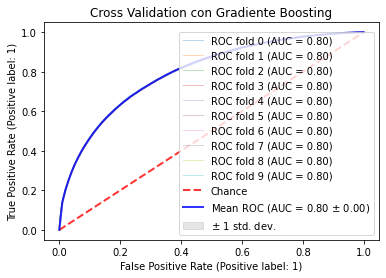

In [ ]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(skf.split(x_bal, y_bal)):
    model.fit(x_bal[train],y_bal[train])
    viz = RocCurveDisplay.from_estimator(
        model,
        x_bal[train],
        y_bal[train],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Cross Validation con Gradiente Boosting",
)
ax.legend(loc="lower right")
plt.show()

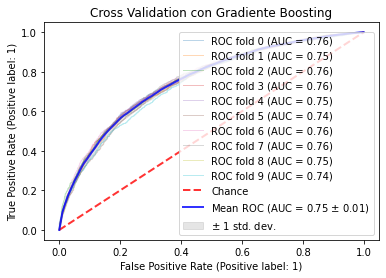

In [ ]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(skf.split(x_bal, y_bal)):
    model.fit(x_bal[train],y_bal[train])
    viz = RocCurveDisplay.from_estimator(
        model,
        x_bal[test],
        y_bal[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Cross Validation con Gradiente Boosting",
)
ax.legend(loc="lower right")
plt.show()